<a href="https://colab.research.google.com/github/ivanshamilov/aiplayground/blob/master/cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import warnings
from pathlib import Path
import numpy as np
import time
from keras.layers import Flatten, GlobalAveragePooling2D, Dense, MaxPool2D, Dropout, Conv2D, ReLU, BatchNormalization
from keras.regularizers import l1, l2

warnings.filterwarnings("ignore")

### Importing data 

1. From `tensorflow-datasets` library
2. Downloading from the Internet and storing as TFRecords, ImageDataGenerator

#### Tensorflow-datasets

In [ ]:
cifar_data, info = tfds.load("cifar10", as_supervised=True, with_info=True)

In [ ]:
info

tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_path='/root/tensorflow_datasets/cifar10/3.0.2',
    file_format=tfrecord,
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learn

In [ ]:
class_names = info.features["label"].names
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
tfds_train_data_raw, tfds_test_data_raw, tfds_valid_data_raw = tfds.load("cifar10", as_supervised=True,
                                                               split=["train[:85%]", "test", "train[85%:]"])

(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)


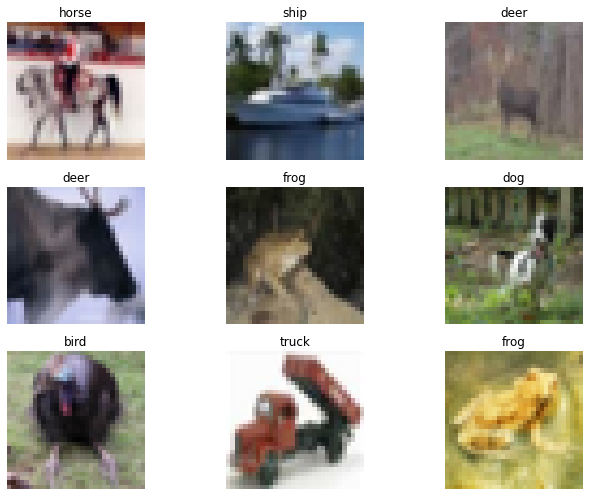

In [ ]:
plt.figure(figsize=(10, 7))
for i, x in enumerate(tfds_train_data_raw.take(9)):
  print(x[0].shape)
  plt.subplot(3, 3, i + 1)
  plt.imshow(x[0])
  plt.axis("off")
  plt.title(class_names[x[1].numpy()])
plt.tight_layout()

In [ ]:
!mkdir models_logs

mkdir: cannot create directory ‘models_logs’: File exists


In [ ]:
augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1)
])

def preprocess_image(image_size, image, label, aug=True, norm=False):
  modified_image = tf.image.resize(image, image_size)
  if aug:
    modified_image = augmentation(modified_image)
  if norm:
    modified_image = modified_image / 255.
  return modified_image, label

In [ ]:
image_size = [128, 128]
batch_size = 32

# tfds_train_data = tfds_train_data_raw.shuffle(1000).batch(batch_size).map(lambda x, y: preprocess_image(image_size, x, y, aug=True)).prefetch(tf.data.AUTOTUNE)
# tfds_test_data = tfds_test_data_raw.shuffle(1000).batch(batch_size).map(lambda x, y: preprocess_image(image_size, x, y, aug=False)).prefetch(tf.data.AUTOTUNE)
# tfds_valid_data = tfds_valid_data_raw.shuffle(1000).batch(batch_size).map(lambda x, y: preprocess_image(image_size, x, y, aug=False)).prefetch(tf.data.AUTOTUNE)

tfds_train_data = tfds_train_data_raw.batch(batch_size).map(lambda x, y: preprocess_image(image_size, x, y, aug=False, norm=True)).prefetch(tf.data.AUTOTUNE)
tfds_train_data_aug = tfds_train_data_raw.batch(batch_size).map(lambda x, y: preprocess_image(image_size, x, y, aug=True, norm=True)).prefetch(tf.data.AUTOTUNE)


# tfds_train_data = tfds_train_data.concatenate(tfds_train_data_aug).shuffle(100)
tfds_valid_data = tfds_valid_data_raw.shuffle(1000).batch(batch_size).map(lambda x, y: preprocess_image(image_size, x, y, aug=False, norm=True)).prefetch(tf.data.AUTOTUNE)
tfds_test_data= tfds_test_data_raw.shuffle(1000).batch(batch_size).map(lambda x, y: preprocess_image(image_size, x, y, aug=False, norm=True)).prefetch(tf.data.AUTOTUNE)

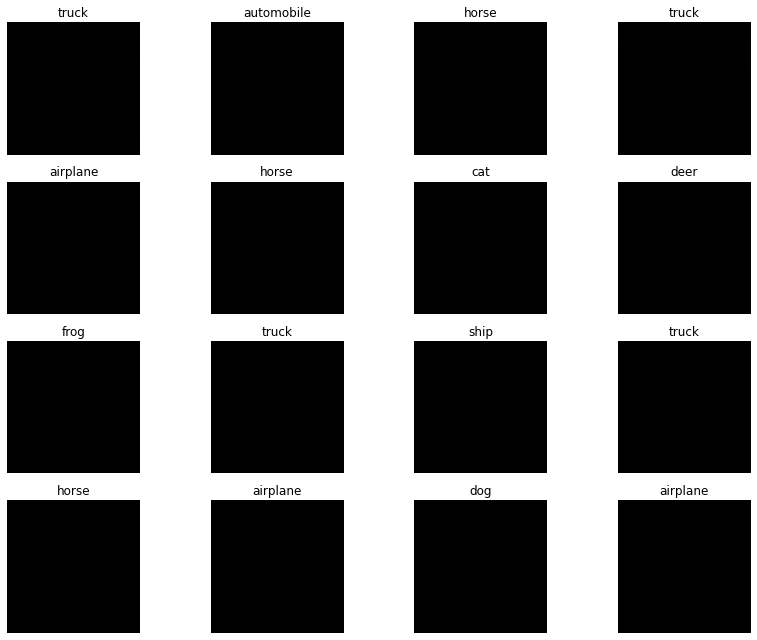

In [ ]:
# Augmentation examples
plt.figure(figsize=(12, 9))
for i, (images, labels) in enumerate(tfds_train_data_aug.take(16)):
  plt.subplot(4, 4, i + 1)
  # image, label = preprocess_image([224, 224], x[0], x[1].numpy(), norm=False)
  plt.imshow(tf.cast(images[7], tf.uint8))
  plt.title(class_names[labels[7]])
  plt.axis("off")
plt.tight_layout()

#### Downloading a dataset from the Internet

In [ ]:
!mkdir cifar_downloaded
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

mkdir: cannot create directory ‘cifar_downloaded’: File exists
--2023-01-08 12:58:57--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz.1’

cifar-10-python.tar 100%[===================>] 162.60M  50.4MB/s    in 3.6s    

2023-01-08 12:59:01 (45.4 MB/s) - ‘cifar-10-python.tar.gz.1’ saved [170498071/170498071]



In [ ]:
import tarfile
from pathlib import Path

zip_path = Path("cifar-10-python.tar.gz")

with tarfile.open(zip_path, "r:gz") as archive:
  archive.extractall("cifar_downloaded/")

In [ ]:
import pickle

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [ ]:
class_names = list(map(lambda x: x.decode("utf-8"), unpickle("/content/cifar_downloaded/cifar-10-batches-py/batches.meta")[b"label_names"]))
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
train_data_files = [f"data_batch_{i}" for i in range(1, 5)]
valid_data_files = ["data_batch_5"]
test_data_files = ["test_batch"]

def prepare_instance(img_array, label):
  tf_image = tf.convert_to_tensor(np.transpose(img_array.reshape(3, 32, 32), axes=(1, 2, 0)), dtype=tf.uint8)
  tf_label = tf.convert_to_tensor(label, dtype=tf.uint8)
  return tf_image, tf_label

def create_tfrecord_example(image, label):
  image_data = tf.io.serialize_tensor(image)
  return tf.train.Example(
      features=tf.train.Features(
          feature={
              "image": tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_data.numpy()])),
              "label": tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))
          }
      )
  )

In [ ]:
from contextlib import ExitStack

def write_tfrecord(name, dataset, n_shards=10):
  paths = ["tfrecord_dataset/{}.tfrecord.{:05d}-of-{:05d}".format(name, index, n_shards) for index in range(1, n_shards + 1)]

  with ExitStack() as stack:
    writers = [stack.enter_context(tf.io.TFRecordWriter(path)) for path in paths]

    for index, (image, label) in enumerate(dataset):
      shard = index % n_shards
      example = create_tfrecord_example(image, label)
      writers[shard].write(example.SerializeToString())

  return paths

In [ ]:
train_dataset_raw = []
test_dataset_raw = []
valid_dataset_raw = []

for dfile in train_data_files:
  temp_data = unpickle(f"cifar_downloaded/cifar-10-batches-py/{dfile}")
  for row, label in zip(temp_data[b"data"], temp_data[b"labels"]):
    train_dataset_raw.append(prepare_instance(row, label))

for dfile in test_data_files:
  temp_data = unpickle(f"cifar_downloaded/cifar-10-batches-py/{dfile}")
  for row, label in zip(temp_data[b"data"], temp_data[b"labels"]):
    test_dataset_raw.append(prepare_instance(row, label))
  
for dfile in valid_data_files:
  temp_data = unpickle(f"cifar_downloaded/cifar-10-batches-py/{dfile}")
  for row, label in zip(temp_data[b"data"], temp_data[b"labels"]):
    valid_dataset_raw.append(prepare_instance(row, label))

In [ ]:
!mkdir tfrecord_dataset

train_filepaths = write_tfrecord("my_cifar.train", train_dataset_raw, 10)
test_filepaths = write_tfrecord("my_cifar.test", test_dataset_raw, 10)
valid_filepaths = write_tfrecord("my_cifar.valid", valid_dataset_raw, 10)

mkdir: cannot create directory ‘tfrecord_dataset’: File exists


In [ ]:
def preprocess_tfrecord(tfrecord):
  feature_descriptions = {
      "image": tf.io.FixedLenFeature([], tf.string, default_value=""),
      "label": tf.io.FixedLenFeature([], tf.int64, default_value=-1)
  }

  example = tf.io.parse_single_example(tfrecord, feature_descriptions)
  image = tf.io.parse_tensor(example["image"], out_type=tf.uint8)
  image = tf.reshape(image, [32, 32, 3])
  
  return image, example["label"]

def cifar_dataset(filepaths, n_read_threads=5, shuffle_buffer_size=None, cache=True, n_parse_threads=5, batch_size=32):
  dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=n_read_threads)
  if cache:
    dataset = dataset.cache()
  if shuffle_buffer_size:
    dataset = dataset.shuffle(shuffle_buffer_size)
  dataset = dataset.map(preprocess_tfrecord, num_parallel_calls=n_parse_threads)
  dataset = dataset.batch(batch_size)

  return dataset.prefetch(tf.data.AUTOTUNE)

In [ ]:
train_set_tfrecord_raw = cifar_dataset(train_filepaths, shuffle_buffer_size=10000)
valid_set_tfrecord_raw = cifar_dataset(valid_filepaths)
test_set_tfrecord_raw = cifar_dataset(test_filepaths)

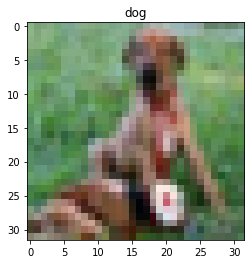

In [ ]:
for (x, y) in train_set_tfrecord_raw.take(1):
  image, label = x[0], y[0]
  plt.imshow(image)
  plt.title(class_names[label.numpy()])

In [ ]:
image_size = [128, 128]

def dataset_from_raw(dataset, image_size, norm=False, with_aug=False):
  dataset_preprocessed = dataset.map(lambda x, y: preprocess_image(image_size, x, y, aug=False, norm=True if norm else False))
  if with_aug:
    dataset_aug = dataset.map(lambda x, y: preprocess_image(image_size, x, y, aug=True, norm=True if norm else False))
    dataset_preprocessed = dataset_preprocessed.concatenate(dataset_aug)
  return dataset_preprocessed.prefetch(tf.data.AUTOTUNE)


train_set_tfrecord = dataset_from_raw(train_set_tfrecord_raw, image_size, norm=True, with_aug=False)
test_set_tfrecord = dataset_from_raw(test_set_tfrecord_raw, image_size, norm=True, with_aug=False)
valid_set_tfrecord = dataset_from_raw(valid_set_tfrecord_raw, image_size, norm=True, with_aug=False)

In [ ]:
train_set_size = 40000
test_set_size = 10000
valid_set_size = 10000

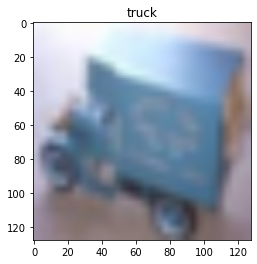

In [ ]:
for (x, y) in train_set_tfrecord.take(1):
  image, label = x[0], y[0]
  plt.imshow(image)
  plt.title(class_names[label])

### Building models

1. Own baseline model (with some additional experiments)
2. Transfer learning

In [ ]:
def plot_loss_curves(history):
  train_loss = history.history["loss"]
  train_acc = history.history["accuracy"]

  val_loss = history.history["val_loss"]
  val_acc = history.history["val_accuracy"]

  epochs = len(train_loss)

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

  ax1.set_title("Losses")
  ax1.plot(range(epochs), train_loss, label="train_loss")
  ax1.plot(range(epochs), val_loss, label="val_loss")
  ax1.legend()

  ax2.set_title("Accuracies")
  ax2.plot(range(epochs), train_acc, label="train_acc")
  ax2.plot(range(epochs), val_acc, label="val_acc")
  ax2.legend()

  plt.show()

In [ ]:
def create_tb_callback(model_name, log_dir="models_logs"):
  return tf.keras.callbacks.TensorBoard(log_dir=Path(log_dir, model_name))

#### Structure 1

In [ ]:
batch_size = 32
epochs = 5

model_0 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),  
    tf.keras.layers.ReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)), 
    tf.keras.layers.ReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),  
    tf.keras.layers.ReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)), 
    tf.keras.layers.ReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=256, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=512, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=1024, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=len(class_names), activation=tf.nn.softmax)
])

model_0.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=["accuracy"])


history_0 = model_0.fit(train_set_tfrecord.repeat(epochs), epochs=epochs, steps_per_epoch=(train_set_size // batch_size), validation_data=valid_set_tfrecord,
                        callbacks=[create_tb_callback(model_name="baseline_model_0_flatten")])

Epoch 1/5
1250/1250 [==============================] - 71s 49ms/step - loss: 1.9177 - accuracy: 0.3726 - val_loss: 1.5276 - val_accuracy: 0.4731
Epoch 2/5
1250/1250 [==============================] - 60s 48ms/step - loss: 1.2848 - accuracy: 0.5444 - val_loss: 1.0752 - val_accuracy: 0.6350
Epoch 3/5
1250/1250 [==============================] - 60s 48ms/step - loss: 0.9932 - accuracy: 0.6545 - val_loss: 2.8002 - val_accuracy: 0.2934
Epoch 4/5
1250/1250 [==============================] - 60s 48ms/step - loss: 0.8314 - accuracy: 0.7136 - val_loss: 1.0248 - val_accuracy: 0.6672
Epoch 5/5
1250/1250 [==============================] - 60s 48ms/step - loss: 0.6856 - accuracy: 0.7650 - val_loss: 0.9279 - val_accuracy: 0.7153


In [ ]:
model_0.evaluate(test_set_tfrecord, steps=(test_set_size // batch_size))

312/312 [==============================] - 6s 20ms/step - loss: 0.8896 - accuracy: 0.7096


[0.8896470665931702, 0.7096354365348816]

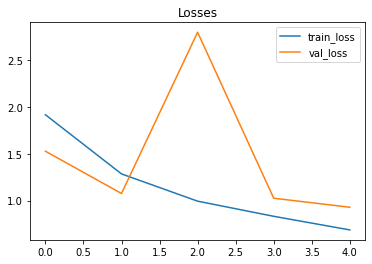

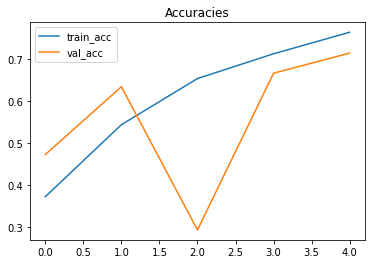

In [ ]:
plot_loss_curves(history_0)

In [ ]:
# Train for longer

batch_size = 32
epochs = 10

model_1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),  
    tf.keras.layers.ReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)), 
    tf.keras.layers.ReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),  
    tf.keras.layers.ReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)), 
    tf.keras.layers.ReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=256, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=512, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=1024, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=len(class_names), activation=tf.nn.softmax)
])

model_1.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=["accuracy"])


history_1 = model_1.fit(train_set_tfrecord.repeat(epochs), epochs=epochs, steps_per_epoch=(train_set_size // batch_size), validation_data=valid_set_tfrecord,
                        callbacks=[create_tb_callback(model_name="baseline_model_1_flatten_more_epochs")])

Epoch 1/10
1250/1250 [==============================] - 67s 53ms/step - loss: 1.8306 - accuracy: 0.3958 - val_loss: 1.4771 - val_accuracy: 0.5006
Epoch 2/10
1250/1250 [==============================] - 61s 49ms/step - loss: 1.1743 - accuracy: 0.5864 - val_loss: 1.1481 - val_accuracy: 0.6144
Epoch 3/10
1250/1250 [==============================] - 60s 48ms/step - loss: 0.9221 - accuracy: 0.6838 - val_loss: 1.0078 - val_accuracy: 0.6606
Epoch 4/10
1250/1250 [==============================] - 60s 48ms/step - loss: 0.7695 - accuracy: 0.7370 - val_loss: 0.9480 - val_accuracy: 0.6945
Epoch 5/10
1250/1250 [==============================] - 60s 48ms/step - loss: 0.6292 - accuracy: 0.7851 - val_loss: 1.0657 - val_accuracy: 0.6812
Epoch 6/10
1250/1250 [==============================] - 60s 48ms/step - loss: 0.5171 - accuracy: 0.8245 - val_loss: 0.8472 - val_accuracy: 0.7303
Epoch 7/10
1250/1250 [==============================] - 60s 48ms/step - loss: 0.4035 - accuracy: 0.8640 - val_loss: 0.8774 -

In [ ]:
model_1.evaluate(test_set_tfrecord, steps=(test_set_size // batch_size)) # overfitted

312/312 [==============================] - 6s 18ms/step - loss: 1.1774 - accuracy: 0.7413


[1.1773955821990967, 0.741286039352417]

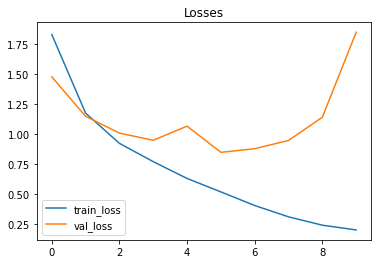

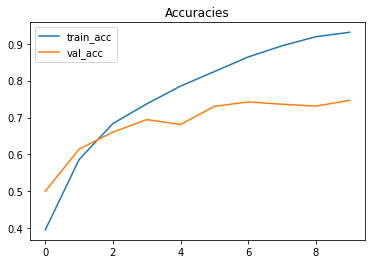

In [ ]:
plot_loss_curves(history_1)

In [ ]:
# Add dropouts

batch_size = 32
epochs = 10

model_2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),  
    tf.keras.layers.ReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)), 
    tf.keras.layers.ReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),  
    tf.keras.layers.ReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)), 
    tf.keras.layers.ReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=256, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=512, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1024, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=len(class_names), activation=tf.nn.softmax)
])

model_2.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=["accuracy"])


history_2 = model_2.fit(train_set_tfrecord.repeat(epochs), epochs=epochs, steps_per_epoch=(train_set_size // batch_size), validation_data=valid_set_tfrecord,
                        callbacks=[create_tb_callback(model_name="baseline_model_2_flatten_dropout")])

Epoch 1/10
1250/1250 [==============================] - 72s 56ms/step - loss: 2.1965 - accuracy: 0.3072 - val_loss: 1.5438 - val_accuracy: 0.4449
Epoch 2/10
1250/1250 [==============================] - 75s 60ms/step - loss: 1.5109 - accuracy: 0.4560 - val_loss: 1.3644 - val_accuracy: 0.5077
Epoch 3/10
1250/1250 [==============================] - 60s 48ms/step - loss: 1.3387 - accuracy: 0.5271 - val_loss: 1.2579 - val_accuracy: 0.5637
Epoch 4/10
1250/1250 [==============================] - 64s 51ms/step - loss: 1.1511 - accuracy: 0.6037 - val_loss: 1.6245 - val_accuracy: 0.5237
Epoch 5/10
1250/1250 [==============================] - 60s 48ms/step - loss: 1.1025 - accuracy: 0.6209 - val_loss: 1.0933 - val_accuracy: 0.6320
Epoch 6/10
1250/1250 [==============================] - 61s 49ms/step - loss: 0.9385 - accuracy: 0.6840 - val_loss: 0.8696 - val_accuracy: 0.7086
Epoch 7/10
1250/1250 [==============================] - 60s 48ms/step - loss: 0.8502 - accuracy: 0.7170 - val_loss: 0.9738 -

In [ ]:
model_2.evaluate(test_set_tfrecord, steps=(test_set_size // batch_size)) # overfitted

312/312 [==============================] - 6s 18ms/step - loss: 147.2341 - accuracy: 0.7229


[147.234130859375, 0.7228565812110901]

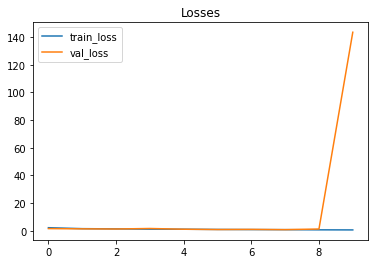

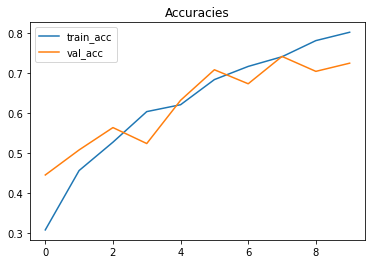

In [ ]:
plot_loss_curves(history_2)

In [ ]:
# Same model with `valid` padding & SGD

batch_size = 32
epochs = 10

model_3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="valid"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),  
    tf.keras.layers.ReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="valid"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)), 
    tf.keras.layers.ReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding="valid"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),  
    tf.keras.layers.ReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="valid"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)), 
    tf.keras.layers.ReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=256, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=512, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1024, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=len(class_names), activation=tf.nn.softmax)
])

model_3.compile(optimizer=tf.keras.optimizers.SGD(lr=0.01),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=["accuracy"])


history_3 = model_3.fit(train_set_tfrecord.repeat(epochs), epochs=epochs, steps_per_epoch=(train_set_size // batch_size), validation_data=valid_set_tfrecord,
                        callbacks=[create_tb_callback(model_name="baseline_model_3_flatten_dropout_valid_sgd")])

Epoch 1/10
1250/1250 [==============================] - 59s 45ms/step - loss: 1.9100 - accuracy: 0.3519 - val_loss: 1.5679 - val_accuracy: 0.4362
Epoch 2/10
1250/1250 [==============================] - 61s 49ms/step - loss: 1.4434 - accuracy: 0.4851 - val_loss: 1.4428 - val_accuracy: 0.4925
Epoch 3/10
1250/1250 [==============================] - 58s 47ms/step - loss: 1.2313 - accuracy: 0.5628 - val_loss: 1.0758 - val_accuracy: 0.6225
Epoch 4/10
1250/1250 [==============================] - 58s 46ms/step - loss: 1.0722 - accuracy: 0.6237 - val_loss: 0.9331 - val_accuracy: 0.6700
Epoch 5/10
1250/1250 [==============================] - 57s 45ms/step - loss: 0.9544 - accuracy: 0.6658 - val_loss: 0.8672 - val_accuracy: 0.6935
Epoch 6/10
1250/1250 [==============================] - 56s 45ms/step - loss: 0.8667 - accuracy: 0.6973 - val_loss: 0.8134 - val_accuracy: 0.7124
Epoch 7/10
1250/1250 [==============================] - 56s 45ms/step - loss: 0.7925 - accuracy: 0.7256 - val_loss: 0.8712 -

In [ ]:
model_3.evaluate(test_set_tfrecord, steps=(test_set_size // batch_size))

312/312 [==============================] - 5s 17ms/step - loss: 0.7960 - accuracy: 0.7327


[0.795985221862793, 0.7326722741127014]

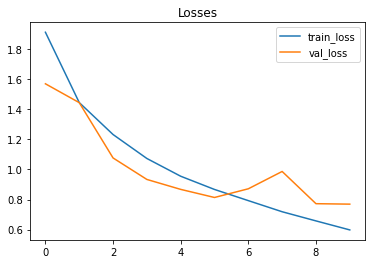

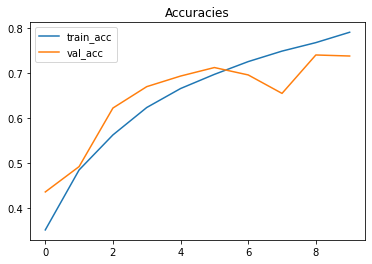

In [ ]:
plot_loss_curves(history_3)

In [ ]:
# Adam 0.02

batch_size = 32
epochs = 10

model_4 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="valid"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),  
    tf.keras.layers.ReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="valid"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)), 
    tf.keras.layers.ReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding="valid"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),  
    tf.keras.layers.ReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="valid"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)), 
    tf.keras.layers.ReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(units=256, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(units=512, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(units=1024, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(units=len(class_names), activation=tf.nn.softmax)
])

model_4.compile(optimizer=tf.keras.optimizers.Adam(lr=0.02),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=["accuracy"])


history_4 = model_4.fit(train_set_tfrecord.repeat(epochs), epochs=epochs, steps_per_epoch=(train_set_size // batch_size), validation_data=valid_set_tfrecord,
                        callbacks=[create_tb_callback(model_name="baseline_model_4_flatten_dropout_valid_adam_02")])

Epoch 1/10
1250/1250 [==============================] - 63s 49ms/step - loss: 2.2258 - accuracy: 0.3025 - val_loss: 1.9202 - val_accuracy: 0.3401
Epoch 2/10
1250/1250 [==============================] - 62s 50ms/step - loss: 1.5952 - accuracy: 0.4309 - val_loss: 1.4385 - val_accuracy: 0.5228
Epoch 3/10
1250/1250 [==============================] - 57s 45ms/step - loss: 1.4454 - accuracy: 0.5006 - val_loss: 1.6394 - val_accuracy: 0.4358
Epoch 4/10
1250/1250 [==============================] - 66s 53ms/step - loss: 1.2955 - accuracy: 0.5596 - val_loss: 3.2539 - val_accuracy: 0.5828
Epoch 5/10
1250/1250 [==============================] - 59s 47ms/step - loss: 1.2245 - accuracy: 0.5928 - val_loss: 15.3517 - val_accuracy: 0.5061
Epoch 6/10
1250/1250 [==============================] - 57s 46ms/step - loss: 1.1532 - accuracy: 0.6163 - val_loss: 41.2415 - val_accuracy: 0.6340
Epoch 7/10
1250/1250 [==============================] - 60s 48ms/step - loss: 1.2682 - accuracy: 0.5873 - val_loss: 1.2446

In [ ]:
model_4.evaluate(test_set_tfrecord, steps=(test_set_size // batch_size))

312/312 [==============================] - 6s 18ms/step - loss: 1.6870 - accuracy: 0.4690


[1.6870245933532715, 0.4689503312110901]

In [ ]:
# Adam 1e-3

batch_size = 32
epochs = 10

model_5 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="valid"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),  
    tf.keras.layers.ReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="valid"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)), 
    tf.keras.layers.ReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding="valid"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),  
    tf.keras.layers.ReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="valid"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)), 
    tf.keras.layers.ReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=256, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=512, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1024, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=len(class_names), activation=tf.nn.softmax)
])

model_5.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=["accuracy"])


history_5 = model_5.fit(train_set_tfrecord.repeat(epochs), epochs=epochs, steps_per_epoch=(train_set_size // batch_size), validation_data=valid_set_tfrecord,
                        callbacks=[create_tb_callback(model_name="baseline_model_5_flatten_dropout_valid_adam_1e-3")])

Epoch 1/10
1250/1250 [==============================] - 59s 46ms/step - loss: 1.8201 - accuracy: 0.3900 - val_loss: 1.3896 - val_accuracy: 0.5090
Epoch 2/10
1250/1250 [==============================] - 57s 45ms/step - loss: 1.2366 - accuracy: 0.5685 - val_loss: 1.0263 - val_accuracy: 0.6506
Epoch 3/10
1250/1250 [==============================] - 63s 50ms/step - loss: 0.9759 - accuracy: 0.6666 - val_loss: 0.9002 - val_accuracy: 0.6926
Epoch 4/10
1250/1250 [==============================] - 59s 47ms/step - loss: 0.8254 - accuracy: 0.7199 - val_loss: 0.8119 - val_accuracy: 0.7195
Epoch 5/10
1250/1250 [==============================] - 60s 48ms/step - loss: 0.6953 - accuracy: 0.7651 - val_loss: 0.9568 - val_accuracy: 0.6827
Epoch 6/10
1250/1250 [==============================] - 61s 49ms/step - loss: 0.5649 - accuracy: 0.8092 - val_loss: 0.7493 - val_accuracy: 0.7460
Epoch 7/10
1250/1250 [==============================] - 56s 45ms/step - loss: 0.4486 - accuracy: 0.8487 - val_loss: 0.7919 -

In [ ]:
model_5.evaluate(test_set_tfrecord, steps=(test_set_size // batch_size))

312/312 [==============================] - 5s 17ms/step - loss: 0.8271 - accuracy: 0.7717


[0.8270933628082275, 0.7717347741127014]

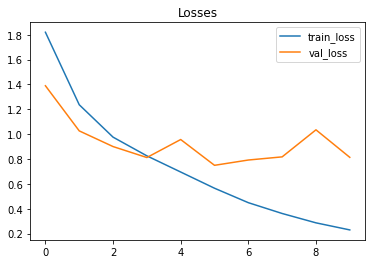

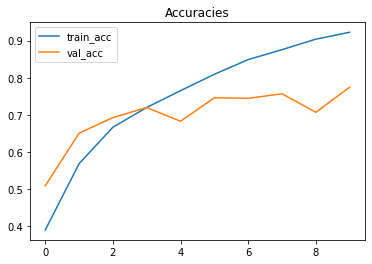

In [ ]:
# Bplot_loss_curves(history_5)

In [ ]:
# Adam 3e-3

batch_size = 32
epochs = 10

model_6 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="valid"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),  
    tf.keras.layers.ReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="valid"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)), 
    tf.keras.layers.ReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding="valid"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),  
    tf.keras.layers.ReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="valid"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)), 
    tf.keras.layers.ReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=256, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=512, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=1024, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=len(class_names), activation=tf.nn.softmax)
])

model_6.compile(optimizer=tf.keras.optimizers.Adam(lr=3e-3),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=["accuracy"])


history_6 = model_6.fit(train_set_tfrecord.repeat(epochs), epochs=epochs, steps_per_epoch=(train_set_size // batch_size), validation_data=valid_set_tfrecord,
                        callbacks=[create_tb_callback(model_name="baseline_model_6_flatten_dropout_0.3_valid_adam_3e-3")])

Epoch 1/10
1250/1250 [==============================] - 60s 46ms/step - loss: 2.0078 - accuracy: 0.3564 - val_loss: 1.5276 - val_accuracy: 0.4706
Epoch 2/10
1250/1250 [==============================] - 58s 47ms/step - loss: 1.3995 - accuracy: 0.5256 - val_loss: 1.6006 - val_accuracy: 0.4481
Epoch 3/10
1250/1250 [==============================] - 57s 46ms/step - loss: 1.1040 - accuracy: 0.6288 - val_loss: 0.9317 - val_accuracy: 0.6787
Epoch 4/10
1250/1250 [==============================] - 57s 45ms/step - loss: 0.9176 - accuracy: 0.6879 - val_loss: 0.9201 - val_accuracy: 0.6745
Epoch 5/10
1250/1250 [==============================] - 58s 46ms/step - loss: 0.7937 - accuracy: 0.7308 - val_loss: 0.7734 - val_accuracy: 0.7369
Epoch 6/10
1250/1250 [==============================] - 57s 45ms/step - loss: 0.6920 - accuracy: 0.7665 - val_loss: 0.7748 - val_accuracy: 0.7336
Epoch 7/10
1250/1250 [==============================] - 57s 45ms/step - loss: 0.5880 - accuracy: 0.8009 - val_loss: 0.7900 -

In [ ]:
model_6.evaluate(test_set_tfrecord, steps=(test_set_size // batch_size))

312/312 [==============================] - 8s 25ms/step - loss: 0.8934 - accuracy: 0.7434


[0.8933748006820679, 0.7433894276618958]

In [ ]:
# Adam 2e-3

batch_size = 32
epochs = 15

model_7 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="valid"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),  
    tf.keras.layers.ReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="valid"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)), 
    tf.keras.layers.ReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding="valid"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),  
    tf.keras.layers.ReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="valid"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)), 
    tf.keras.layers.ReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(units=256, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(units=512, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(units=1024, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(units=len(class_names), activation=tf.nn.softmax)
])

model_7.compile(optimizer=tf.keras.optimizers.Adam(lr=2e-3),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=["accuracy"])


history_7 = model_7.fit(train_set_tfrecord.repeat(epochs), epochs=epochs, steps_per_epoch=(train_set_size // batch_size), validation_data=valid_set_tfrecord,
                        callbacks=[create_tb_callback(model_name="baseline_model_7_flatten_dropout_0.25_valid_adam_2e-3")])

Epoch 1/15
1250/1250 [==============================] - 86s 67ms/step - loss: 1.9231 - accuracy: 0.3673 - val_loss: 1.4275 - val_accuracy: 0.5084
Epoch 2/15
1250/1250 [==============================] - 83s 66ms/step - loss: 1.2622 - accuracy: 0.5676 - val_loss: 0.9936 - val_accuracy: 0.6522
Epoch 3/15
1250/1250 [==============================] - 85s 68ms/step - loss: 1.0314 - accuracy: 0.6550 - val_loss: 0.9095 - val_accuracy: 0.6867
Epoch 4/15
1250/1250 [==============================] - 79s 63ms/step - loss: 0.8593 - accuracy: 0.7102 - val_loss: 1.0663 - val_accuracy: 0.6464
Epoch 5/15
1250/1250 [==============================] - 86s 69ms/step - loss: 0.7356 - accuracy: 0.7516 - val_loss: 0.7886 - val_accuracy: 0.7276
Epoch 6/15
1250/1250 [==============================] - 84s 67ms/step - loss: 0.6235 - accuracy: 0.7905 - val_loss: 0.7765 - val_accuracy: 0.7424
Epoch 7/15
1250/1250 [==============================] - 83s 67ms/step - loss: 0.5096 - accuracy: 0.8289 - val_loss: 0.7611 -

In [ ]:
model_7.evaluate(test_set_tfrecord, steps=(test_set_size // batch_size))

312/312 [==============================] - 7s 23ms/step - loss: 0.9978 - accuracy: 0.7641


[0.997783362865448, 0.7641226053237915]

In [ ]:
batch_size = 64

train_set_tfrecord_raw_64 = cifar_dataset(train_filepaths, batch_size=batch_size, shuffle_buffer_size=10000)
valid_set_tfrecord_raw_64 = cifar_dataset(valid_filepaths, batch_size=batch_size)
test_set_tfrecord_raw_64 = cifar_dataset(test_filepaths, batch_size=batch_size)

train_set_tfrecord_64 = dataset_from_raw(train_set_tfrecord_raw, image_size, norm=True, with_aug=False)
test_set_tfrecord_64 = dataset_from_raw(test_set_tfrecord_raw, image_size, norm=True, with_aug=False)
valid_set_tfrecord_64 = dataset_from_raw(valid_set_tfrecord_raw, image_size, norm=True, with_aug=False)

In [ ]:
# Best previous model (model_5) with batch_size = 64

epochs = 10

model_8 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="valid"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),  
    tf.keras.layers.ReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="valid"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)), 
    tf.keras.layers.ReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding="valid"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),  
    tf.keras.layers.ReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="valid"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)), 
    tf.keras.layers.ReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(units=256, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(units=512, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(units=1024, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(units=len(class_names), activation=tf.nn.softmax)
])

model_8.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=["accuracy"])


history_8 = model_8.fit(train_set_tfrecord_64.repeat(epochs), epochs=epochs, steps_per_epoch=(train_set_size // batch_size), validation_data=valid_set_tfrecord_64,
                        callbacks=[create_tb_callback(model_name="batch64_model_8_flatten_dropout_valid_adam_1e-3")])

Epoch 1/10
625/625 [==============================] - 37s 57ms/step - loss: 2.1386 - accuracy: 0.3166 - val_loss: 1.5386 - val_accuracy: 0.4496
Epoch 2/10
625/625 [==============================] - 31s 50ms/step - loss: 1.5706 - accuracy: 0.4498 - val_loss: 2.5087 - val_accuracy: 0.3291
Epoch 3/10
625/625 [==============================] - 32s 51ms/step - loss: 1.3326 - accuracy: 0.5338 - val_loss: 1.5154 - val_accuracy: 0.4747
Epoch 4/10
625/625 [==============================] - 36s 58ms/step - loss: 1.1851 - accuracy: 0.5872 - val_loss: 1.0958 - val_accuracy: 0.6206
Epoch 5/10
625/625 [==============================] - 32s 52ms/step - loss: 1.0500 - accuracy: 0.6413 - val_loss: 1.1293 - val_accuracy: 0.6055
Epoch 6/10
625/625 [==============================] - 31s 50ms/step - loss: 0.9870 - accuracy: 0.6602 - val_loss: 1.0135 - val_accuracy: 0.6464
Epoch 7/10
625/625 [==============================] - 38s 61ms/step - loss: 0.8638 - accuracy: 0.7077 - val_loss: 0.9136 - val_accuracy:

In [ ]:
model_8.evaluate(test_set_tfrecord_64, steps=(test_set_size // batch_size))

156/156 [==============================] - 3s 17ms/step - loss: 0.8099 - accuracy: 0.7276


[0.8099161982536316, 0.7275640964508057]

In [ ]:
batch_size = 32

train_set_tfrecord_raw_32 = cifar_dataset(train_filepaths, batch_size=batch_size, shuffle_buffer_size=10000)
valid_set_tfrecord_raw_32 = cifar_dataset(valid_filepaths, batch_size=batch_size)
test_set_tfrecord_raw_32 = cifar_dataset(test_filepaths, batch_size=batch_size)

train_set_tfrecord_32 = dataset_from_raw(train_set_tfrecord_raw, image_size, norm=True, with_aug=False)
test_set_tfrecord_32 = dataset_from_raw(test_set_tfrecord_raw, image_size, norm=True, with_aug=False)
valid_set_tfrecord_32 = dataset_from_raw(valid_set_tfrecord_raw, image_size, norm=True, with_aug=False)

In [ ]:
# Best model (model_5) with GlobalAveragePooling2D

epochs = 10

model_9 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="valid"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),  
    tf.keras.layers.ReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="valid"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)), 
    tf.keras.layers.ReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding="valid"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),  
    tf.keras.layers.ReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="valid"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)), 
    tf.keras.layers.ReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(units=128, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=256, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=512, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1024, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=len(class_names), activation=tf.nn.softmax)
])

model_9.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=["accuracy"])


history_9 = model_9.fit(train_set_tfrecord_32.repeat(epochs), epochs=epochs, steps_per_epoch=(train_set_size // batch_size), validation_data=valid_set_tfrecord_32,
                        callbacks=[create_tb_callback(model_name="model_10_globalaveragepooling_dropout_valid_adam_1e-3")])

Epoch 1/10
1250/1250 [==============================] - 61s 47ms/step - loss: 1.9891 - accuracy: 0.3176 - val_loss: 2.5442 - val_accuracy: 0.2768
Epoch 2/10
1250/1250 [==============================] - 61s 49ms/step - loss: 1.4762 - accuracy: 0.4734 - val_loss: 1.4380 - val_accuracy: 0.4932
Epoch 3/10
1250/1250 [==============================] - 57s 46ms/step - loss: 1.2331 - accuracy: 0.5673 - val_loss: 1.1236 - val_accuracy: 0.6051
Epoch 4/10
1250/1250 [==============================] - 57s 46ms/step - loss: 1.0445 - accuracy: 0.6402 - val_loss: 1.1119 - val_accuracy: 0.6188
Epoch 5/10
1250/1250 [==============================] - 56s 45ms/step - loss: 0.9051 - accuracy: 0.6899 - val_loss: 0.9424 - val_accuracy: 0.6657
Epoch 6/10
1250/1250 [==============================] - 56s 45ms/step - loss: 0.7923 - accuracy: 0.7293 - val_loss: 0.9257 - val_accuracy: 0.6900
Epoch 7/10
1250/1250 [==============================] - 56s 45ms/step - loss: 0.6981 - accuracy: 0.7639 - val_loss: 1.0765 -

In [ ]:
model_9.evaluate(test_set_tfrecord_32, steps=(test_set_size // batch_size))

312/312 [==============================] - 5s 17ms/step - loss: 0.9536 - accuracy: 0.7013


[0.9535629153251648, 0.7013221383094788]

#### Structure 2

##### VGG Block 1

In [ ]:
class VGGBlock(tf.keras.layers.Layer):
  def __init__(self, num_convs=2, num_filters=128):
    super(VGGBlock, self).__init__()
    self.model = tf.keras.Sequential()
    for _ in range(num_convs):
      self.model.add(Conv2D(filters=num_filters, kernel_size=(3, 3), padding="same", activation=tf.nn.relu))
    self.model.add(MaxPool2D(pool_size=(2, 2), strides=2))
  
  def call(self, X):
    return self.model(X)

In [ ]:
image_size = [32, 32]
batch_size = 32

train_set_tfrecord_raw = cifar_dataset(train_filepaths, batch_size=batch_size, shuffle_buffer_size=10000)
valid_set_tfrecord_raw = cifar_dataset(valid_filepaths, batch_size=batch_size)
test_set_tfrecord_raw = cifar_dataset(test_filepaths, batch_size=batch_size)

train_set_tfrecord = dataset_from_raw(train_set_tfrecord_raw, image_size, norm=True, with_aug=False)
test_set_tfrecord = dataset_from_raw(test_set_tfrecord_raw, image_size, norm=True, with_aug=False)
valid_set_tfrecord = dataset_from_raw(valid_set_tfrecord_raw, image_size, norm=True, with_aug=False)

In [ ]:
epochs = 20

model1_0 = tf.keras.Sequential([
    VGGBlock(num_convs=2, num_filters=32),
    Flatten(),
    Dense(units=128, activation="relu"),
    Dense(units=len(class_names), activation="softmax")
])

model1_0.compile(optimizer=tf.keras.optimizers.SGD(lr=1e-3, momentum=0.9),
                  loss=tf.keras.losses.sparse_categorical_crossentropy,
                  metrics=["accuracy"])

history1_0 = model1_0.fit(train_set_tfrecord.repeat(epochs), epochs=epochs, steps_per_epoch=(train_set_size // batch_size), 
                          validation_data=valid_set_tfrecord, validation_steps=(valid_set_size // batch_size))

Epoch 1/20
1250/1250 [==============================] - 9s 7ms/step - loss: 1.8871 - accuracy: 0.3286 - val_loss: 1.6768 - val_accuracy: 0.4031
Epoch 2/20
1250/1250 [==============================] - 8s 6ms/step - loss: 1.5547 - accuracy: 0.4489 - val_loss: 1.4436 - val_accuracy: 0.4918
Epoch 3/20
1250/1250 [==============================] - 7s 6ms/step - loss: 1.3628 - accuracy: 0.5156 - val_loss: 1.3768 - val_accuracy: 0.5108
Epoch 4/20
1250/1250 [==============================] - 7s 6ms/step - loss: 1.2234 - accuracy: 0.5663 - val_loss: 1.2378 - val_accuracy: 0.5716
Epoch 5/20
1250/1250 [==============================] - 7s 6ms/step - loss: 1.1169 - accuracy: 0.6061 - val_loss: 1.1678 - val_accuracy: 0.5892
Epoch 6/20
1250/1250 [==============================] - 8s 6ms/step - loss: 1.0278 - accuracy: 0.6391 - val_loss: 1.1139 - val_accuracy: 0.6107
Epoch 7/20
1250/1250 [==============================] - 8s 6ms/step - loss: 0.9514 - accuracy: 0.6644 - val_loss: 1.0869 - val_accuracy:

In [ ]:
model1_0.evaluate(test_set_tfrecord, steps=(test_set_size // batch_size))

312/312 [==============================] - 1s 4ms/step - loss: 1.4782 - accuracy: 0.6508


[1.4781544208526611, 0.6508413553237915]

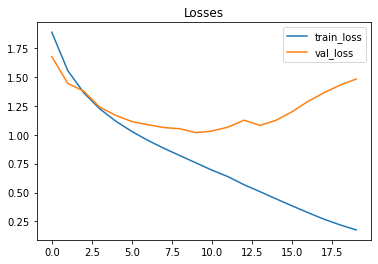

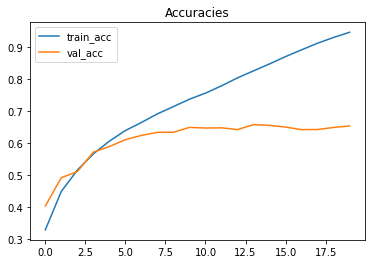

In [ ]:
plot_loss_curves(history1_0)

In [ ]:
epochs = 20

model1_0_adam = tf.keras.Sequential([
    VGGBlock(num_convs=2, num_filters=32),
    Flatten(),
    Dense(units=128, activation="relu"),
    Dense(units=len(class_names), activation="softmax")
])

model1_0_adam.compile(optimizer=tf.keras.optimizers.Adam(lr=2e-3, decay=0.001),
                  loss=tf.keras.losses.sparse_categorical_crossentropy,
                  metrics=["accuracy"])

history1_0_adam = model1_0_adam.fit(train_set_tfrecord.repeat(epochs), epochs=epochs, steps_per_epoch=(train_set_size // batch_size), 
                          validation_data=valid_set_tfrecord, validation_steps=(valid_set_size // batch_size))

Epoch 1/20
1250/1250 [==============================] - 8s 6ms/step - loss: 1.3724 - accuracy: 0.5105 - val_loss: 1.0923 - val_accuracy: 0.6185
Epoch 2/20
1250/1250 [==============================] - 8s 6ms/step - loss: 0.9687 - accuracy: 0.6583 - val_loss: 1.0048 - val_accuracy: 0.6496
Epoch 3/20
1250/1250 [==============================] - 7s 6ms/step - loss: 0.7992 - accuracy: 0.7182 - val_loss: 0.9450 - val_accuracy: 0.6726
Epoch 4/20
1250/1250 [==============================] - 7s 6ms/step - loss: 0.6799 - accuracy: 0.7632 - val_loss: 0.9479 - val_accuracy: 0.6807
Epoch 5/20
1250/1250 [==============================] - 7s 6ms/step - loss: 0.5875 - accuracy: 0.7962 - val_loss: 0.9636 - val_accuracy: 0.6809
Epoch 6/20
1250/1250 [==============================] - 7s 6ms/step - loss: 0.5090 - accuracy: 0.8278 - val_loss: 1.0021 - val_accuracy: 0.6812
Epoch 7/20
1250/1250 [==============================] - 7s 6ms/step - loss: 0.4425 - accuracy: 0.8534 - val_loss: 1.0434 - val_accuracy:

In [ ]:
model1_0_adam.evaluate(test_set_tfrecord, steps=(test_set_size // batch_size))

312/312 [==============================] - 1s 4ms/step - loss: 1.8856 - accuracy: 0.6463


[1.8856433629989624, 0.6463341116905212]

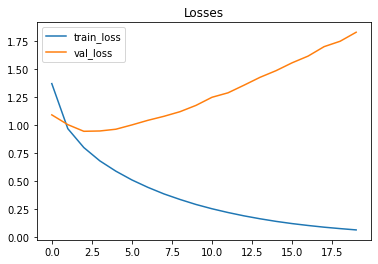

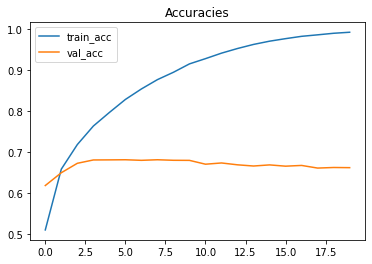

In [ ]:
plot_loss_curves(history1_0_adam)

##### VGG Block 2

Epoch 1/20
1250/1250 [==============================] - 9s 7ms/step - loss: 1.4780 - accuracy: 0.4627 - val_loss: 1.1447 - val_accuracy: 0.5925
Epoch 2/20
1250/1250 [==============================] - 8s 6ms/step - loss: 1.0144 - accuracy: 0.6413 - val_loss: 0.9547 - val_accuracy: 0.6649
Epoch 3/20
1250/1250 [==============================] - 8s 7ms/step - loss: 0.8430 - accuracy: 0.7033 - val_loss: 0.8987 - val_accuracy: 0.6843
Epoch 4/20
1250/1250 [==============================] - 11s 9ms/step - loss: 0.7336 - accuracy: 0.7414 - val_loss: 0.8974 - val_accuracy: 0.6863
Epoch 5/20
1250/1250 [==============================] - 8s 6ms/step - loss: 0.6545 - accuracy: 0.7705 - val_loss: 0.8396 - val_accuracy: 0.7130
Epoch 6/20
1250/1250 [==============================] - 8s 6ms/step - loss: 0.5896 - accuracy: 0.7925 - val_loss: 0.8310 - val_accuracy: 0.7182
Epoch 7/20
1250/1250 [==============================] - 8s 7ms/step - loss: 0.5356 - accuracy: 0.8145 - val_loss: 0.8350 - val_accuracy

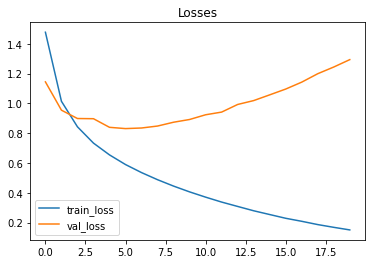

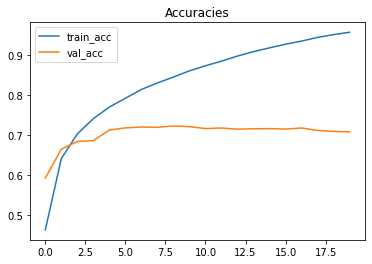

In [ ]:
epochs = 20

model1_1 = tf.keras.Sequential([
    VGGBlock(num_convs=2, num_filters=32),
    VGGBlock(num_convs=2, num_filters=64),
    Flatten(),
    Dense(units=128, activation="relu"),
    Dense(units=len(class_names), activation="softmax")
])

model1_1.compile(optimizer=tf.keras.optimizers.Adam(lr=2e-3, decay=0.001),
                  loss=tf.keras.losses.sparse_categorical_crossentropy,
                  metrics=["accuracy"])

history1_1 = model1_1.fit(train_set_tfrecord.repeat(epochs), epochs=epochs, steps_per_epoch=(train_set_size // batch_size), 
                          validation_data=valid_set_tfrecord, validation_steps=(valid_set_size // batch_size))

print(model1_1.evaluate(test_set_tfrecord, steps=(test_set_size // batch_size)))
plot_loss_curves(history1_1)

##### VGG Block 3

Epoch 1/20
1250/1250 [==============================] - 10s 7ms/step - loss: 1.6239 - accuracy: 0.3958 - val_loss: 1.3164 - val_accuracy: 0.5190
Epoch 2/20
1250/1250 [==============================] - 9s 7ms/step - loss: 1.1757 - accuracy: 0.5776 - val_loss: 1.1489 - val_accuracy: 0.5905
Epoch 3/20
1250/1250 [==============================] - 9s 7ms/step - loss: 0.9806 - accuracy: 0.6492 - val_loss: 0.9731 - val_accuracy: 0.6550
Epoch 4/20
1250/1250 [==============================] - 9s 7ms/step - loss: 0.8567 - accuracy: 0.6937 - val_loss: 0.9132 - val_accuracy: 0.6782
Epoch 5/20
1250/1250 [==============================] - 9s 7ms/step - loss: 0.7642 - accuracy: 0.7302 - val_loss: 0.8711 - val_accuracy: 0.6950
Epoch 6/20
1250/1250 [==============================] - 9s 7ms/step - loss: 0.6900 - accuracy: 0.7548 - val_loss: 0.8493 - val_accuracy: 0.7110
Epoch 7/20
1250/1250 [==============================] - 9s 7ms/step - loss: 0.6298 - accuracy: 0.7757 - val_loss: 0.8407 - val_accuracy

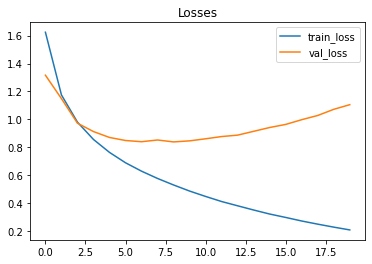

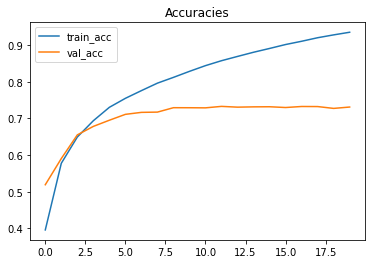

In [ ]:
epochs = 20

model1_2 = tf.keras.Sequential([
    VGGBlock(num_convs=2, num_filters=32),
    VGGBlock(num_convs=2, num_filters=64),
    VGGBlock(num_convs=2, num_filters=128),
    Flatten(),
    Dense(units=128, activation="relu"),
    Dense(units=len(class_names), activation="softmax")
])

model1_2.compile(optimizer=tf.keras.optimizers.Adam(lr=2e-3, decay=0.001),
                  loss=tf.keras.losses.sparse_categorical_crossentropy,
                  metrics=["accuracy"])

history1_2 = model1_2.fit(train_set_tfrecord.repeat(epochs), epochs=epochs, steps_per_epoch=(train_set_size // batch_size), 
                          validation_data=valid_set_tfrecord, validation_steps=(valid_set_size // batch_size))

print(model1_2.evaluate(test_set_tfrecord, steps=(test_set_size // batch_size)))
plot_loss_curves(history1_2)

* VGG with 1 block - 65.65% accuracy
* VGG with 2 blocks - 70.5% accuracy
* VGG with 3 blocks - 73.3% accuracy

Nevertheless each of them is overfitted.

**Let's try adding dropout:**

##### VGG Block 3 + Dropout

Epoch 1/50
1250/1250 [==============================] - 11s 8ms/step - loss: 2.1361 - accuracy: 0.2000 - val_loss: 1.9768 - val_accuracy: 0.2735
Epoch 2/50
1250/1250 [==============================] - 9s 7ms/step - loss: 1.8534 - accuracy: 0.3252 - val_loss: 1.7807 - val_accuracy: 0.3593
Epoch 3/50
1250/1250 [==============================] - 9s 8ms/step - loss: 1.6604 - accuracy: 0.3924 - val_loss: 1.5635 - val_accuracy: 0.4296
Epoch 4/50
1250/1250 [==============================] - 9s 7ms/step - loss: 1.5520 - accuracy: 0.4349 - val_loss: 1.4474 - val_accuracy: 0.4790
Epoch 5/50
1250/1250 [==============================] - 9s 7ms/step - loss: 1.4615 - accuracy: 0.4703 - val_loss: 1.3368 - val_accuracy: 0.5214
Epoch 6/50
1250/1250 [==============================] - 9s 7ms/step - loss: 1.3877 - accuracy: 0.4985 - val_loss: 1.3173 - val_accuracy: 0.5315
Epoch 7/50
1250/1250 [==============================] - 9s 8ms/step - loss: 1.3255 - accuracy: 0.5223 - val_loss: 1.2318 - val_accuracy

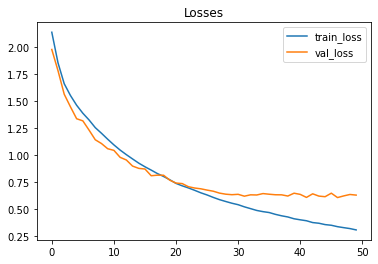

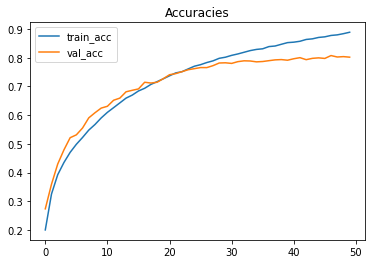

In [ ]:
epochs = 50

model1_3 = tf.keras.Sequential([
    VGGBlock(num_convs=2, num_filters=32),
    Dropout(0.2),
    VGGBlock(num_convs=2, num_filters=64),
    Dropout(0.2),
    VGGBlock(num_convs=2, num_filters=128),
    Dropout(0.2),
    Flatten(),
    Dense(units=128, activation="relu"),
    Dropout(0.2),
    Dense(units=len(class_names), activation="softmax")
])

model1_3.compile(optimizer=tf.keras.optimizers.SGD(lr=1e-3, momentum=0.9),
                  loss=tf.keras.losses.sparse_categorical_crossentropy,
                  metrics=["accuracy"])

history1_3 = model1_3.fit(train_set_tfrecord.repeat(epochs), epochs=epochs, steps_per_epoch=(train_set_size // batch_size), 
                          validation_data=valid_set_tfrecord, validation_steps=(valid_set_size // batch_size))

print(model1_3.evaluate(test_set_tfrecord, steps=(test_set_size // batch_size)))
plot_loss_curves(history1_3)

And lets try putting Dropout **before** MaxPool2D

In [ ]:
class VGGBlockDropout(tf.keras.layers.Layer):
  def __init__(self, num_convs=2, num_filters=128, dropout_rate=0.2):
    super(VGGBlockDropout, self).__init__()
    self.model = tf.keras.Sequential()
    for _ in range(num_convs):
      self.model.add(Conv2D(filters=num_filters, kernel_size=(3, 3), padding="same", activation=tf.nn.relu))
    self.model.add(Dropout(dropout_rate))
    self.model.add(MaxPool2D(pool_size=(2, 2), strides=2))
  
  def call(self, X):
    return self.model(X)

Epoch 1/50
1250/1250 [==============================] - 13s 8ms/step - loss: 1.9899 - accuracy: 0.2753 - val_loss: 1.8221 - val_accuracy: 0.3900
Epoch 2/50
1250/1250 [==============================] - 9s 7ms/step - loss: 1.6010 - accuracy: 0.4245 - val_loss: 1.6031 - val_accuracy: 0.4686
Epoch 3/50
1250/1250 [==============================] - 10s 8ms/step - loss: 1.4288 - accuracy: 0.4880 - val_loss: 1.4397 - val_accuracy: 0.5276
Epoch 4/50
1250/1250 [==============================] - 9s 7ms/step - loss: 1.2955 - accuracy: 0.5401 - val_loss: 1.3276 - val_accuracy: 0.5661
Epoch 5/50
1250/1250 [==============================] - 10s 8ms/step - loss: 1.1900 - accuracy: 0.5758 - val_loss: 1.2398 - val_accuracy: 0.5936
Epoch 6/50
1250/1250 [==============================] - 9s 8ms/step - loss: 1.0858 - accuracy: 0.6176 - val_loss: 1.2097 - val_accuracy: 0.6101
Epoch 7/50
1250/1250 [==============================] - 9s 8ms/step - loss: 0.9915 - accuracy: 0.6524 - val_loss: 1.0563 - val_accura

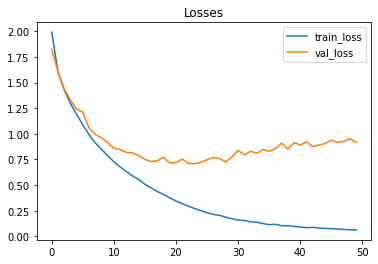

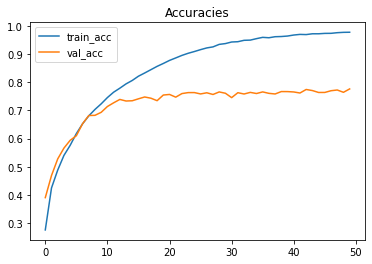

In [ ]:
epochs = 50
model1_4 = tf.keras.Sequential([
    VGGBlockDropout(num_convs=2, num_filters=32, dropout_rate=0.2),
    VGGBlockDropout(num_convs=2, num_filters=64, dropout_rate=0.2),
    VGGBlockDropout(num_convs=2, num_filters=128, dropout_rate=0.2),
    Flatten(),
    Dense(units=128, activation=tf.nn.relu),
    Dense(units=len(class_names), activation=tf.nn.softmax)
])

model1_4.compile(optimizer=tf.keras.optimizers.SGD(lr=1e-3, momentum=0.9),
                 loss=tf.keras.losses.sparse_categorical_crossentropy,
                 metrics=["accuracy"])

history1_4 = model1_4.fit(train_set_tfrecord.repeat(epochs), steps_per_epoch=(train_set_size // batch_size),
                          epochs=epochs, validation_data=valid_set_tfrecord, validation_steps=(valid_set_size // batch_size))
print(model1_4.evaluate(test_set_tfrecord, steps=(test_set_size // batch_size)))

plot_loss_curves(history1_4)

Better to use Dropout after MaxPool2D (79% vs 76%)

##### VGG Block 3 + Weight decay

Weight decay or weight regularization - updating loss function to penalize the model in proportion to the size of the model weights. Larger weights result in a more complex and less stable model, whereas smaller weights are often more stable and more general.

In [ ]:
class VGGBlockRegularized(tf.keras.layers.Layer):
  def __init__(self, num_convs=2, num_filters=128, regularization_rate=0.001):
    super(VGGBlockRegularized, self).__init__()
    self.model = tf.keras.Sequential()
    for _ in range(num_convs):
      self.model.add(Conv2D(filters=num_filters, kernel_size=(3, 3), padding="same", activation=tf.nn.relu, kernel_regularizer=l2(regularization_rate)))
    self.model.add(MaxPool2D(pool_size=(2, 2), strides=2))
  
  def call(self, X):
    return self.model(X)

Epoch 1/50
1250/1250 [==============================] - 11s 8ms/step - loss: 2.4538 - accuracy: 0.2413 - val_loss: 2.3002 - val_accuracy: 0.3071
Epoch 2/50
1250/1250 [==============================] - 9s 8ms/step - loss: 2.0818 - accuracy: 0.3820 - val_loss: 1.9444 - val_accuracy: 0.4330
Epoch 3/50
1250/1250 [==============================] - 9s 8ms/step - loss: 1.8944 - accuracy: 0.4439 - val_loss: 1.8417 - val_accuracy: 0.4606
Epoch 4/50
1250/1250 [==============================] - 9s 7ms/step - loss: 1.7826 - accuracy: 0.4777 - val_loss: 1.7693 - val_accuracy: 0.4848
Epoch 5/50
1250/1250 [==============================] - 9s 7ms/step - loss: 1.6991 - accuracy: 0.5079 - val_loss: 1.6864 - val_accuracy: 0.5110
Epoch 6/50
1250/1250 [==============================] - 9s 7ms/step - loss: 1.6220 - accuracy: 0.5342 - val_loss: 1.7032 - val_accuracy: 0.5062
Epoch 7/50
1250/1250 [==============================] - 9s 8ms/step - loss: 1.5563 - accuracy: 0.5548 - val_loss: 1.6636 - val_accuracy

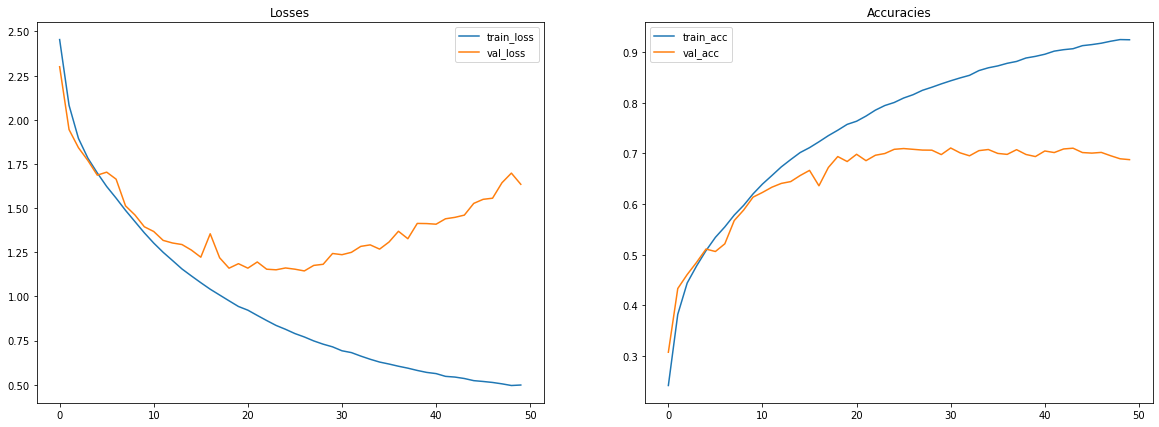

In [ ]:
epochs = 50
model1_5 = tf.keras.Sequential([
    VGGBlockRegularized(num_convs=2, num_filters=32, regularization_rate=0.001),
    VGGBlockRegularized(num_convs=2, num_filters=32, regularization_rate=0.001),
    VGGBlockRegularized(num_convs=2, num_filters=32, regularization_rate=0.001),
    Flatten(),
    Dense(units=128, activation=tf.nn.relu, kernel_regularizer=l2(0.001)),
    Dense(units=len(class_names), activation=tf.nn.softmax)
])

model1_5.compile(optimizer=tf.keras.optimizers.SGD(lr=1e-3, momentum=0.9),
                 loss=tf.keras.losses.sparse_categorical_crossentropy,
                 metrics=["accuracy"])

history1_5 = model1_5.fit(train_set_tfrecord.repeat(epochs), steps_per_epoch=(train_set_size // batch_size),
                          epochs=epochs, validation_data=valid_set_tfrecord, validation_steps=(valid_set_size // batch_size))
print(model1_5.evaluate(test_set_tfrecord, steps=(test_set_size // batch_size)))

plot_loss_curves(history1_5)

The accuracy dropped comparing to the initial VGG Block 3 model + model overfitting

##### VGG Block 3 + Increasing dropout + Batch normalization

Increasing dropout might help the deeper layers of the network to be regularized more than the ones that are closer to the input

Also, let's try to change the optimizer to Adam with the decay of 0.001

In [ ]:
train_set_tfrecord_raw = cifar_dataset(train_filepaths, batch_size=batch_size, shuffle_buffer_size=10000)
valid_set_tfrecord_raw = cifar_dataset(valid_filepaths, batch_size=batch_size)
test_set_tfrecord_raw = cifar_dataset(test_filepaths, batch_size=batch_size)

train_set_tfrecord = dataset_from_raw(train_set_tfrecord_raw, image_size, norm=True, with_aug=False)
test_set_tfrecord = dataset_from_raw(test_set_tfrecord_raw, image_size, norm=True, with_aug=False)
valid_set_tfrecord = dataset_from_raw(valid_set_tfrecord_raw, image_size, norm=True, with_aug=False)

In [ ]:
class VGGBlockBatchNormalized(tf.keras.layers.Layer):
  def __init__(self, num_convs=2, num_filters=128):
    super(VGGBlockBatchNormalized, self).__init__()
    self.model = tf.keras.Sequential()
    for _ in range(num_convs):
      self.model.add(Conv2D(filters=num_filters, kernel_size=(3, 3), padding="same", activation=tf.nn.relu))
      self.model.add(BatchNormalization())
    self.model.add(MaxPool2D(pool_size=(2, 2), strides=2))
  
  def call(self, X):
    return self.model(X)

Epoch 1/50
1250/1250 [==============================] - 13s 9ms/step - loss: 1.5610 - accuracy: 0.4539 - val_loss: 1.3111 - val_accuracy: 0.5388
Epoch 2/50
1250/1250 [==============================] - 12s 9ms/step - loss: 1.0583 - accuracy: 0.6291 - val_loss: 1.0368 - val_accuracy: 0.6387
Epoch 3/50
1250/1250 [==============================] - 11s 9ms/step - loss: 0.8814 - accuracy: 0.6950 - val_loss: 0.7261 - val_accuracy: 0.7452
Epoch 4/50
1250/1250 [==============================] - 11s 9ms/step - loss: 0.7790 - accuracy: 0.7297 - val_loss: 0.6675 - val_accuracy: 0.7600
Epoch 5/50
1250/1250 [==============================] - 11s 9ms/step - loss: 0.7050 - accuracy: 0.7576 - val_loss: 0.6287 - val_accuracy: 0.7766
Epoch 6/50
1250/1250 [==============================] - 12s 9ms/step - loss: 0.6586 - accuracy: 0.7751 - val_loss: 0.5849 - val_accuracy: 0.7917
Epoch 7/50
1250/1250 [==============================] - 11s 9ms/step - loss: 0.6182 - accuracy: 0.7879 - val_loss: 0.5551 - val_ac

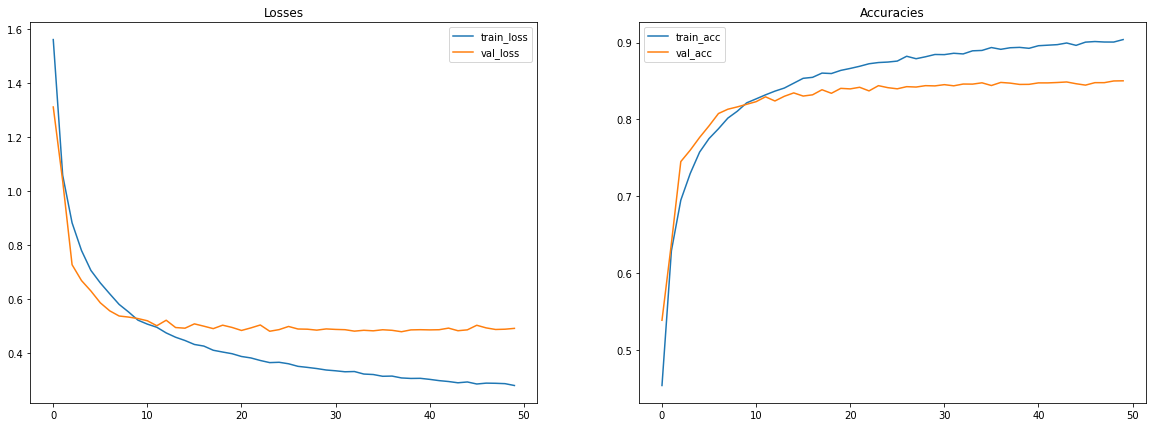

In [ ]:
epochs = 50

model1_7 = tf.keras.Sequential([
    VGGBlockBatchNormalized(num_convs=2, num_filters=32),
    Dropout(0.2),
    VGGBlockBatchNormalized(num_convs=2, num_filters=64),
    Dropout(0.3),
    VGGBlockBatchNormalized(num_convs=2, num_filters=128),
    Dropout(0.4),
    Flatten(),
    Dense(units=128, activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(units=len(class_names), activation="softmax")
])

model1_7.compile(optimizer=tf.keras.optimizers.Adam(lr=2e-3, decay=0.001),
                  loss=tf.keras.losses.sparse_categorical_crossentropy,
                  metrics=["accuracy"])

history1_7 = model1_7.fit(train_set_tfrecord.repeat(epochs), epochs=epochs, steps_per_epoch=(train_set_size // batch_size), 
                          validation_data=valid_set_tfrecord, validation_steps=(valid_set_size // batch_size))

print(model1_7.evaluate(test_set_tfrecord, steps=(test_set_size // batch_size)))
plot_loss_curves(history1_7)

Epoch 1/100
1250/1250 [==============================] - 17s 12ms/step - loss: 1.9291 - accuracy: 0.3367 - val_loss: 1.4512 - val_accuracy: 0.4784
Epoch 2/100
1250/1250 [==============================] - 15s 12ms/step - loss: 1.4416 - accuracy: 0.4798 - val_loss: 1.1312 - val_accuracy: 0.5948
Epoch 3/100
1250/1250 [==============================] - 15s 12ms/step - loss: 1.2481 - accuracy: 0.5558 - val_loss: 0.9867 - val_accuracy: 0.6529
Epoch 4/100
1250/1250 [==============================] - 15s 12ms/step - loss: 1.1263 - accuracy: 0.6026 - val_loss: 0.9019 - val_accuracy: 0.6756
Epoch 5/100
1250/1250 [==============================] - 15s 12ms/step - loss: 1.0446 - accuracy: 0.6350 - val_loss: 0.8386 - val_accuracy: 0.6997
Epoch 6/100
1250/1250 [==============================] - 15s 12ms/step - loss: 0.9812 - accuracy: 0.6559 - val_loss: 0.8035 - val_accuracy: 0.7121
Epoch 7/100
1250/1250 [==============================] - 15s 12ms/step - loss: 0.9290 - accuracy: 0.6762 - val_loss: 0

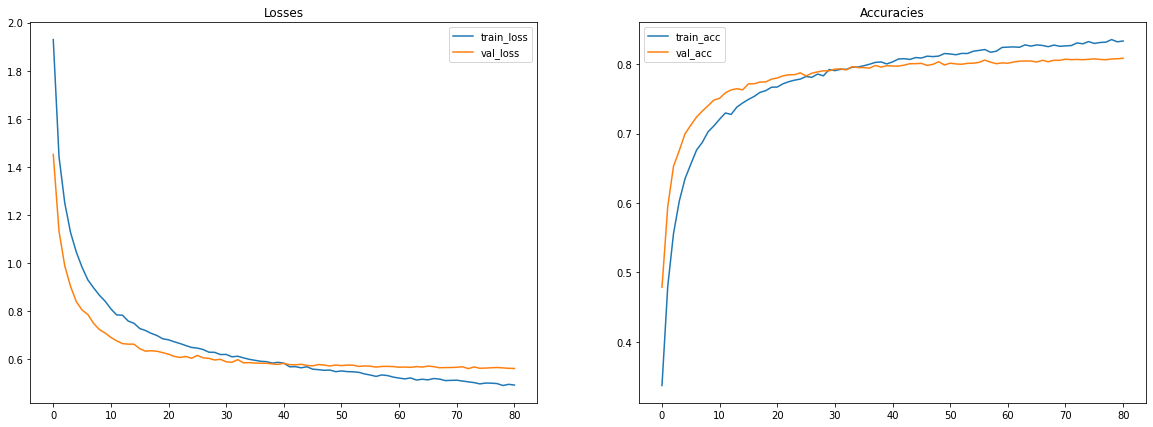

In [ ]:
epochs = 100

es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=8)

model1_8 = tf.keras.Sequential([
    VGGBlockBatchNormalized(num_convs=4, num_filters=32),
    Dropout(0.1),
    VGGBlockBatchNormalized(num_convs=3, num_filters=64),
    Dropout(0.2),
    VGGBlockBatchNormalized(num_convs=2, num_filters=128),
    Dropout(0.3),
    Flatten(),
    Dense(units=64, activation="relu"),
    BatchNormalization(),
    Dropout(0.4),
    Dense(units=128, activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(units=len(class_names), activation="softmax")
])

model1_8.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3, decay=0.002),
                  loss=tf.keras.losses.sparse_categorical_crossentropy,
                  metrics=["accuracy"])

history1_8 = model1_8.fit(train_set_tfrecord.repeat(epochs), epochs=epochs, steps_per_epoch=(train_set_size // batch_size), 
                          validation_data=valid_set_tfrecord, validation_steps=(valid_set_size // batch_size), callbacks=[es_callback])

print(model1_8.evaluate(test_set_tfrecord, steps=(test_set_size // batch_size)))
plot_loss_curves(history1_8)

In [ ]:
class VGGBlockBatchNormalizedRegularized(tf.keras.layers.Layer):
  def __init__(self, num_convs=2, num_filters=128, regularization_rate=0.001):
    super(VGGBlockBatchNormalizedRegularized, self).__init__()
    self.model = tf.keras.Sequential()
    for _ in range(num_convs):
      self.model.add(Conv2D(filters=num_filters, kernel_size=(3, 3), padding="same", activation=tf.nn.relu, kernel_regularizer=l2(regularization_rate)))
      self.model.add(BatchNormalization())
    self.model.add(MaxPool2D(pool_size=(2, 2), strides=2))
  
  def call(self, X):
    return self.model(X)

Epoch 1/100
1250/1250 [==============================] - 18s 13ms/step - loss: 2.2875 - accuracy: 0.3352 - val_loss: 1.6974 - val_accuracy: 0.5081
Epoch 2/100
1250/1250 [==============================] - 16s 13ms/step - loss: 1.7757 - accuracy: 0.4859 - val_loss: 1.4707 - val_accuracy: 0.5932
Epoch 3/100
1250/1250 [==============================] - 16s 13ms/step - loss: 1.5707 - accuracy: 0.5656 - val_loss: 1.3115 - val_accuracy: 0.6555
Epoch 4/100
1250/1250 [==============================] - 16s 12ms/step - loss: 1.4423 - accuracy: 0.6114 - val_loss: 1.2328 - val_accuracy: 0.6743
Epoch 5/100
1250/1250 [==============================] - 16s 13ms/step - loss: 1.3452 - accuracy: 0.6448 - val_loss: 1.1642 - val_accuracy: 0.6962
Epoch 6/100
1250/1250 [==============================] - 16s 13ms/step - loss: 1.2792 - accuracy: 0.6690 - val_loss: 1.1150 - val_accuracy: 0.7164
Epoch 7/100
1250/1250 [==============================] - 16s 13ms/step - loss: 1.2265 - accuracy: 0.6873 - val_loss: 1

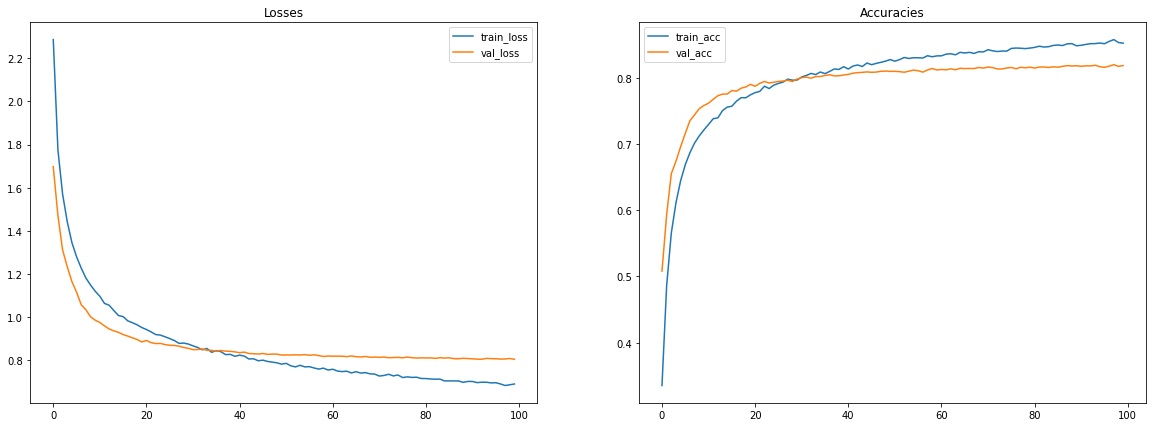

In [ ]:
epochs = 100

es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=8)

model1_9 = tf.keras.Sequential([
    VGGBlockBatchNormalizedRegularized(num_convs=4, num_filters=32, regularization_rate=0.0005),
    Dropout(0.1),
    VGGBlockBatchNormalizedRegularized(num_convs=3, num_filters=64, regularization_rate=0.0005),
    Dropout(0.2),
    VGGBlockBatchNormalizedRegularized(num_convs=2, num_filters=128, regularization_rate=0.0005),
    Dropout(0.3),
    Flatten(),
    Dense(units=64, activation="relu", kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(units=128, activation="relu", kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(units=len(class_names), activation="softmax")
])

model1_9.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3, decay=0.002),
                  loss=tf.keras.losses.sparse_categorical_crossentropy,
                  metrics=["accuracy"])

history1_9 = model1_9.fit(train_set_tfrecord.repeat(epochs), epochs=epochs, steps_per_epoch=(train_set_size // batch_size), 
                          validation_data=valid_set_tfrecord, validation_steps=(valid_set_size // batch_size), callbacks=[es_callback])

print(model1_9.evaluate(test_set_tfrecord, steps=(test_set_size // batch_size)))
plot_loss_curves(history1_9)

Epoch 1/100
1250/1250 [==============================] - 14s 10ms/step - loss: 2.0031 - accuracy: 0.4257 - val_loss: 1.5603 - val_accuracy: 0.5630
Epoch 2/100
1250/1250 [==============================] - 12s 9ms/step - loss: 1.4497 - accuracy: 0.5959 - val_loss: 1.2118 - val_accuracy: 0.6805
Epoch 3/100
1250/1250 [==============================] - 12s 9ms/step - loss: 1.2531 - accuracy: 0.6646 - val_loss: 1.0581 - val_accuracy: 0.7275
Epoch 4/100
1250/1250 [==============================] - 12s 10ms/step - loss: 1.1360 - accuracy: 0.7028 - val_loss: 1.0299 - val_accuracy: 0.7298
Epoch 5/100
1250/1250 [==============================] - 13s 11ms/step - loss: 1.0568 - accuracy: 0.7269 - val_loss: 0.9053 - val_accuracy: 0.7704
Epoch 6/100
1250/1250 [==============================] - 12s 9ms/step - loss: 0.9843 - accuracy: 0.7469 - val_loss: 0.8902 - val_accuracy: 0.7757
Epoch 7/100
1250/1250 [==============================] - 12s 9ms/step - loss: 0.9354 - accuracy: 0.7616 - val_loss: 0.835

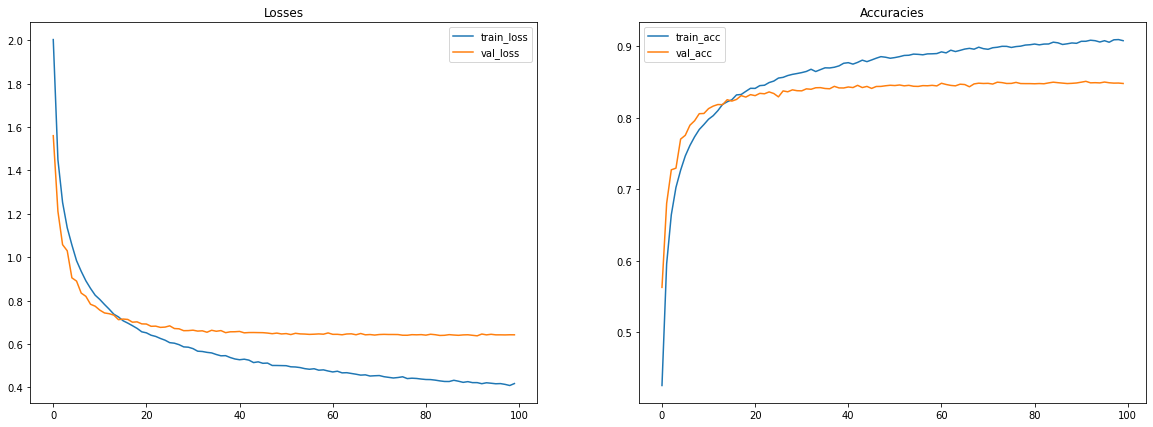

In [ ]:
epochs = 100

model1_10 = tf.keras.Sequential([
    VGGBlockBatchNormalizedRegularized(num_convs=2, num_filters=32, regularization_rate=0.0005),
    Dropout(0.2),
    VGGBlockBatchNormalizedRegularized(num_convs=2, num_filters=64, regularization_rate=0.0005),
    Dropout(0.3),
    VGGBlockBatchNormalizedRegularized(num_convs=2, num_filters=128, regularization_rate=0.0005),
    Dropout(0.4), 
    Flatten(),
    Dense(units=128, activation="relu", kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(units=len(class_names), activation="softmax")
])

model1_10.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3, decay=0.001),
                  loss=tf.keras.losses.sparse_categorical_crossentropy,
                  metrics=["accuracy"])

history1_10 = model1_10.fit(train_set_tfrecord.repeat(epochs), epochs=epochs, steps_per_epoch=(train_set_size // batch_size), 
                          validation_data=valid_set_tfrecord, validation_steps=(valid_set_size // batch_size))

print(model1_10.evaluate(test_set_tfrecord, steps=(test_set_size // batch_size)))
plot_loss_curves(history1_10)

#### Transfer Learning

In [ ]:
image_size = [128, 128]

train_set_tfrecord = dataset_from_raw(train_set_tfrecord_raw, image_size, norm=True, with_aug=False)
test_set_tfrecord = dataset_from_raw(test_set_tfrecord_raw, image_size, norm=True, with_aug=False)
valid_set_tfrecord = dataset_from_raw(valid_set_tfrecord_raw, image_size, norm=True, with_aug=False)

##### MobileNetV2

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 3),
                                               include_top=False,
                                               weights="imagenet")

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_set_tfrecord))
feature_batch = base_model(image_batch)
feature_batch.shape

TensorShape([32, 4, 4, 1280])

In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
feature_batch_average.shape

TensorShape([32, 1280])

In [ ]:
prediction_layer = tf.keras.layers.Dense(units=len(class_names), activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
np.argmax(prediction_batch, axis=1)

array([7, 5, 9, 9, 7, 7, 7, 7, 7, 7, 7, 9, 7, 7, 7, 7, 8, 7, 7, 7, 8, 0,
       7, 7, 7, 7, 3, 7, 7, 7, 8, 7])

In [ ]:
inputs = tf.keras.Input(shape=(128, 128, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(units=128, activation="relu")(x)
outputs = tf.keras.layers.Dense(units=len(class_names), activation="softmax")(x)

modelt_1 = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
modelt_1.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
                 loss=tf.keras.losses.sparse_categorical_crossentropy,
                 metrics=["accuracy"])

In [ ]:
modelt_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_4   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               163968    
                                                                 
 dense_7 (Dense)             (None, 10)                1290

In [ ]:
len(modelt_1.trainable_variables)

4

In [ ]:
loss0, accuracy0 = modelt_1.evaluate(valid_set_tfrecord, steps=(valid_set_size // batch_size))

312/312 [==============================] - 7s 19ms/step - loss: 2.6577 - accuracy: 0.1200


In [ ]:
initial_epochs = 10

history = modelt_1.fit(train_set_tfrecord.repeat(initial_epochs),
                       epochs=initial_epochs,
                       steps_per_epoch=(train_set_size // batch_size),
                       validation_data=valid_set_tfrecord,
                       validation_steps=(valid_set_size // batch_size))

Epoch 1/10
1250/1250 [==============================] - 30s 24ms/step - loss: 0.7885 - accuracy: 0.7232 - val_loss: 0.7038 - val_accuracy: 0.7560
Epoch 2/10
1250/1250 [==============================] - 29s 23ms/step - loss: 0.7224 - accuracy: 0.7469 - val_loss: 0.6645 - val_accuracy: 0.7698
Epoch 3/10
1250/1250 [==============================] - 29s 23ms/step - loss: 0.6837 - accuracy: 0.7610 - val_loss: 0.6387 - val_accuracy: 0.7781
Epoch 4/10
1250/1250 [==============================] - 29s 23ms/step - loss: 0.6578 - accuracy: 0.7694 - val_loss: 0.6224 - val_accuracy: 0.7845
Epoch 5/10
1250/1250 [==============================] - 29s 23ms/step - loss: 0.6394 - accuracy: 0.7778 - val_loss: 0.6169 - val_accuracy: 0.7889
Epoch 6/10
1250/1250 [==============================] - 29s 23ms/step - loss: 0.6251 - accuracy: 0.7805 - val_loss: 0.6161 - val_accuracy: 0.7886
Epoch 7/10
1250/1250 [==============================] - 29s 23ms/step - loss: 0.6133 - accuracy: 0.7863 - val_loss: 0.6050 -

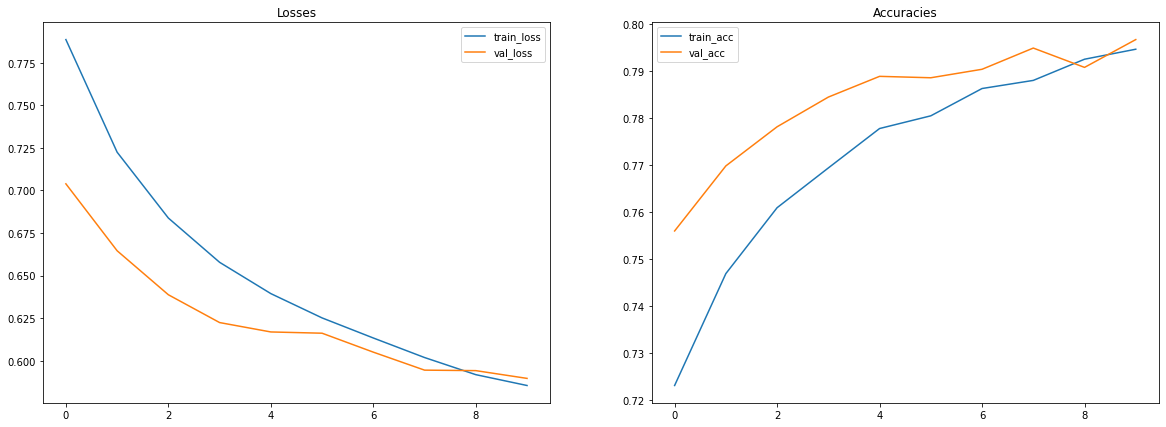

In [ ]:
plot_loss_curves(history)

In [ ]:
base_model.trainable = True 

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
modelt_1.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate / 10),
                 loss=tf.keras.losses.sparse_categorical_crossentropy,
                 metrics=["accuracy"])
modelt_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_4   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               163968    
                                                                 
 dense_7 (Dense)             (None, 10)                1290

In [ ]:
len(modelt_1.trainable_variables)

58

In [ ]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = modelt_1.fit(train_set_tfrecord.repeat(fine_tune_epochs),
                            steps_per_epoch=(train_set_size // batch_size),
                            validation_data=valid_set_tfrecord,
                            validation_steps=(valid_set_size // batch_size),
                            epochs=total_epochs,
                            initial_epoch=history.epoch[-1])

Epoch 10/20
1250/1250 [==============================] - 47s 32ms/step - loss: 0.5250 - accuracy: 0.8162 - val_loss: 0.4932 - val_accuracy: 0.8298
Epoch 11/20
1250/1250 [==============================] - 40s 32ms/step - loss: 0.4307 - accuracy: 0.8498 - val_loss: 0.4458 - val_accuracy: 0.8438
Epoch 12/20
1250/1250 [==============================] - 45s 36ms/step - loss: 0.3692 - accuracy: 0.8708 - val_loss: 0.4268 - val_accuracy: 0.8567
Epoch 13/20
1250/1250 [==============================] - 41s 33ms/step - loss: 0.3177 - accuracy: 0.8882 - val_loss: 0.4129 - val_accuracy: 0.8578
Epoch 14/20
1250/1250 [==============================] - 41s 32ms/step - loss: 0.2778 - accuracy: 0.9020 - val_loss: 0.3828 - val_accuracy: 0.8725
Epoch 15/20
1250/1250 [==============================] - 41s 33ms/step - loss: 0.2447 - accuracy: 0.9143 - val_loss: 0.3756 - val_accuracy: 0.8742
Epoch 16/20
1250/1250 [==============================] - 41s 33ms/step - loss: 0.2136 - accuracy: 0.9259 - val_loss: 0

1250/1250 [==============================] - 6s 5ms/step - loss: 0.1401 - accuracy: 0.9505 - val_loss: 0.3910 - val_accuracy: 0.8820


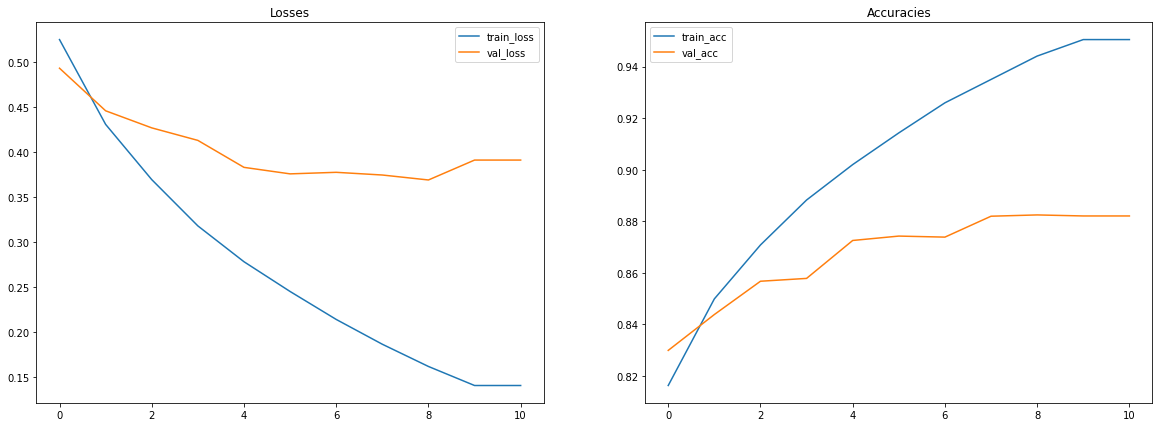

In [ ]:
plot_loss_curves(history_fine)

##### Inception

In [ ]:
inception_v3_link = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"

In [ ]:
classifier = tf.keras.Sequential([
    hub.KerasLayer(inception_v3_link, input_shape=(128, 128, 3))
])

In [ ]:
result = classifier.predict(tf.expand_dims(image, axis=0))
tf.math.argmax(result[0], axis=-1)

1/1 [==============================] - 0s 26ms/step


<tf.Tensor: shape=(), dtype=int64, numpy=868>

In [ ]:
for image_batch, label_batch in train_set_tfrecord:
  print(image_batch.shape, label_batch.shape)
  break

(32, 128, 128, 3) (32,)


In [ ]:
inception_feature_extractor = "https://tfhub.dev/google/imagenet/inception_v3/feature_vector/5"

feature_extractor_layer = hub.KerasLayer(
    inception_feature_extractor,
    input_shape=(128, 128, 3),
    trainable=False
)

In [ ]:
feature_batch = feature_extractor_layer(image_batch)
feature_batch.shape

TensorShape([32, 2048])

In [ ]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    tf.keras.layers.Dense(units=len(class_names))
])

In [ ]:
model.predict(image_batch).shape

1/1 [==============================] - 1s 993ms/step


(32, 10)

In [ ]:
num_epochs = 10

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

history = model.fit(train_set_tfrecord.repeat(num_epochs),
                    steps_per_epoch=(train_set_size // batch_size),
                    validation_data=valid_set_tfrecord,
                    validation_steps=(valid_set_size // batch_size),
                    epochs=num_epochs)

Epoch 1/10
1250/1250 [==============================] - 52s 37ms/step - loss: 0.9188 - accuracy: 0.7263 - val_loss: 0.7672 - val_accuracy: 0.7694
Epoch 2/10
1250/1250 [==============================] - 45s 36ms/step - loss: 0.7303 - accuracy: 0.7802 - val_loss: 0.7682 - val_accuracy: 0.7774
Epoch 3/10
1250/1250 [==============================] - 45s 36ms/step - loss: 0.6694 - accuracy: 0.7926 - val_loss: 0.7876 - val_accuracy: 0.7772
Epoch 4/10
1250/1250 [==============================] - 46s 36ms/step - loss: 0.6342 - accuracy: 0.8030 - val_loss: 0.7581 - val_accuracy: 0.7878
Epoch 5/10
1250/1250 [==============================] - 57s 46ms/step - loss: 0.6222 - accuracy: 0.8070 - val_loss: 0.7801 - val_accuracy: 0.7796
Epoch 6/10
1250/1250 [==============================] - 54s 44ms/step - loss: 0.5902 - accuracy: 0.8169 - val_loss: 0.8771 - val_accuracy: 0.7694
Epoch 7/10
1250/1250 [==============================] - 54s 44ms/step - loss: 0.5836 - accuracy: 0.8184 - val_loss: 0.8415 -

In [ ]:
epochs = 5

model_1 = tf.keras.Sequential([
    feature_extractor_layer,
    tf.keras.layers.Dense(units=256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=len(class_names), activation="softmax")
])

model_1.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
                loss=tf.keras.losses.sparse_categorical_crossentropy,
                metrics=["accuracy"])

history_1 = model_1.fit(train_set_tfrecord.repeat(epochs),
                        steps_per_epoch=(train_set_size // batch_size),
                        validation_data=valid_set_tfrecord,
                        validation_steps=(valid_set_size // batch_size),
                        epochs=epochs)

Epoch 1/5
1250/1250 [==============================] - 50s 37ms/step - loss: 0.8491 - accuracy: 0.7212 - val_loss: 0.6848 - val_accuracy: 0.7676
Epoch 2/5
1250/1250 [==============================] - 44s 36ms/step - loss: 0.6663 - accuracy: 0.7714 - val_loss: 0.6680 - val_accuracy: 0.7723
Epoch 3/5
1250/1250 [==============================] - 48s 38ms/step - loss: 0.6096 - accuracy: 0.7914 - val_loss: 0.6100 - val_accuracy: 0.7966
Epoch 4/5
1250/1250 [==============================] - 57s 45ms/step - loss: 0.5663 - accuracy: 0.8028 - val_loss: 0.6524 - val_accuracy: 0.7925
Epoch 5/5
1250/1250 [==============================] - 57s 46ms/step - loss: 0.5324 - accuracy: 0.8143 - val_loss: 0.6398 - val_accuracy: 0.7878


In [ ]:
feature_extractor_layer.trainable = True

In [ ]:
fine_tune_epochs = 5

total_epochs = epochs + fine_tune_epochs

model_1.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001 / 10),
                loss=tf.keras.losses.sparse_categorical_crossentropy,
                metrics=["accuracy"])

model_1.fit(train_set_tfrecord.repeat(fine_tune_epochs + 1),
            steps_per_epoch=(train_set_size // batch_size),
            validation_data=valid_set_tfrecord,
            validation_steps=(valid_set_size // batch_size),
            epochs=total_epochs,
            initial_epoch=5)

Epoch 6/10
1250/1250 [==============================] - 144s 111ms/step - loss: 0.6468 - accuracy: 0.8649 - val_loss: 0.5138 - val_accuracy: 0.9052
Epoch 7/10
1250/1250 [==============================] - 136s 109ms/step - loss: 0.4614 - accuracy: 0.9255 - val_loss: 0.4997 - val_accuracy: 0.9177
Epoch 8/10
1250/1250 [==============================] - 135s 108ms/step - loss: 0.3885 - accuracy: 0.9494 - val_loss: 0.4899 - val_accuracy: 0.9233
Epoch 9/10
1250/1250 [==============================] - 135s 108ms/step - loss: 0.3583 - accuracy: 0.9590 - val_loss: 0.4799 - val_accuracy: 0.9243
Epoch 10/10
1250/1250 [==============================] - 135s 108ms/step - loss: 0.3277 - accuracy: 0.9702 - val_loss: 0.4995 - val_accuracy: 0.9225


##### Xception (`tf.keras.applications`)

In [ ]:
xception_base_model = tf.keras.applications.xception.Xception(
    include_top=False,
    input_shape=(128, 128, 3),
    weights="imagenet"
)

xception_base_model.summary()

83683744/83683744 [==============================] - 2s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 63, 63, 32)   864         ['input_25[0][0]']               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 63, 63, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                          

In [ ]:
xception_base_model.trainable = False

In [ ]:
image_batch, label_batch = next(iter(train_set_tfrecord))

xception_base_model(image_batch).shape

TensorShape([32, 4, 4, 2048])

In [ ]:
inputs = tf.keras.Input(shape=(128, 128, 3))
x = xception_base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(units=256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(units=len(class_names), activation="softmax")(x)

xception_model = tf.keras.Model(inputs, outputs)

In [ ]:
xception_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
                       loss=tf.keras.losses.sparse_categorical_crossentropy,
                       metrics=["accuracy"])

xception_model.evaluate(test_set_tfrecord, steps=(test_set_size // batch_size))

312/312 [==============================] - 15s 44ms/step - loss: 2.4477 - accuracy: 0.1283


[2.447664260864258, 0.12830528616905212]

In [ ]:
initial_epochs = 10

xception_history = xception_model.fit(train_set_tfrecord.repeat(initial_epochs),
                                      steps_per_epoch=(train_set_size // batch_size),
                                      validation_data=valid_set_tfrecord,
                                      validation_steps=(valid_set_size // batch_size),
                                      epochs=initial_epochs)

Epoch 1/10
1250/1250 [==============================] - 71s 55ms/step - loss: 0.7590 - accuracy: 0.7480 - val_loss: 0.6569 - val_accuracy: 0.7743
Epoch 2/10
1250/1250 [==============================] - 68s 55ms/step - loss: 0.5965 - accuracy: 0.7942 - val_loss: 0.5938 - val_accuracy: 0.7958
Epoch 3/10
1250/1250 [==============================] - 68s 54ms/step - loss: 0.5273 - accuracy: 0.8157 - val_loss: 0.5966 - val_accuracy: 0.7924
Epoch 4/10
1250/1250 [==============================] - 79s 63ms/step - loss: 0.4767 - accuracy: 0.8332 - val_loss: 0.5927 - val_accuracy: 0.8025
Epoch 5/10
1250/1250 [==============================] - 75s 60ms/step - loss: 0.4308 - accuracy: 0.8469 - val_loss: 0.6032 - val_accuracy: 0.8035
Epoch 6/10
1250/1250 [==============================] - 71s 57ms/step - loss: 0.3850 - accuracy: 0.8644 - val_loss: 0.6073 - val_accuracy: 0.8048
Epoch 7/10
1250/1250 [==============================] - 68s 55ms/step - loss: 0.3522 - accuracy: 0.8737 - val_loss: 0.6245 -

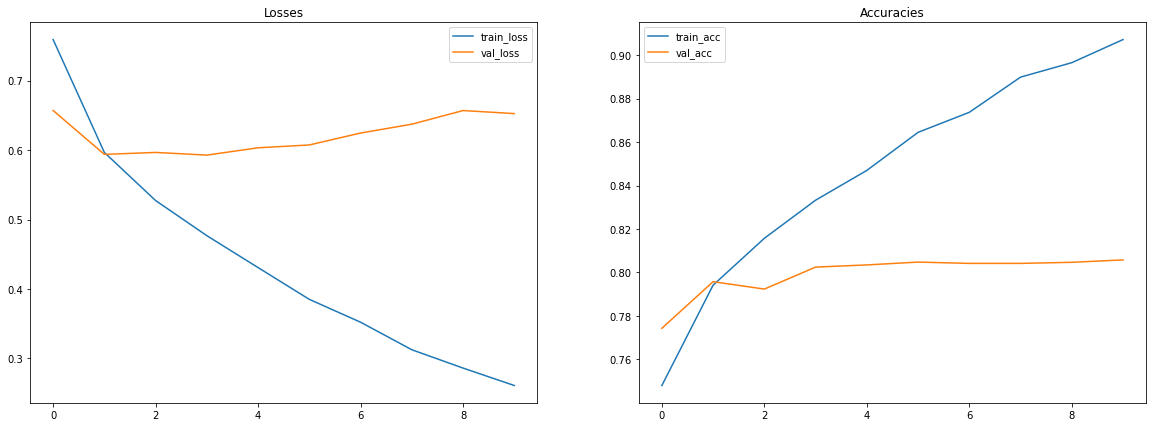

In [ ]:
plot_loss_curves(xception_history)

In [ ]:
len(xception_base_model.layers)

132

In [ ]:
xception_base_model.trainable = True

fine_tune_at = 100

for layer in xception_base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
xception_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001 / 10),
                       loss=tf.keras.losses.sparse_categorical_crossentropy,
                       metrics=["accuracy"])

fine_tune_epochs = 10

total_epochs = initial_epochs + fine_tune_epochs

xception_history_ft = xception_model.fit(train_set_tfrecord.repeat(fine_tune_epochs + 1),
                                        steps_per_epoch=(train_set_size // batch_size),
                                        validation_data=valid_set_tfrecord,
                                        validation_steps=(valid_set_size // batch_size),
                                        epochs=total_epochs,
                                        initial_epoch=xception_history.epoch[-1])

Epoch 10/20
1250/1250 [==============================] - 108s 84ms/step - loss: 0.3311 - accuracy: 0.8834 - val_loss: 0.4879 - val_accuracy: 0.8482
Epoch 11/20
1250/1250 [==============================] - 100s 80ms/step - loss: 0.1936 - accuracy: 0.9329 - val_loss: 0.5159 - val_accuracy: 0.8607
Epoch 12/20
1250/1250 [==============================] - 107s 86ms/step - loss: 0.1330 - accuracy: 0.9542 - val_loss: 0.5268 - val_accuracy: 0.8565
Epoch 13/20
1250/1250 [==============================] - 100s 80ms/step - loss: 0.0985 - accuracy: 0.9656 - val_loss: 0.5431 - val_accuracy: 0.8692
Epoch 14/20
1250/1250 [==============================] - 100s 80ms/step - loss: 0.0737 - accuracy: 0.9749 - val_loss: 0.5806 - val_accuracy: 0.8739
Epoch 15/20
1250/1250 [==============================] - 100s 80ms/step - loss: 0.0594 - accuracy: 0.9790 - val_loss: 0.5496 - val_accuracy: 0.8790
Epoch 16/20
1250/1250 [==============================] - 100s 80ms/step - loss: 0.0576 - accuracy: 0.9811 - val_

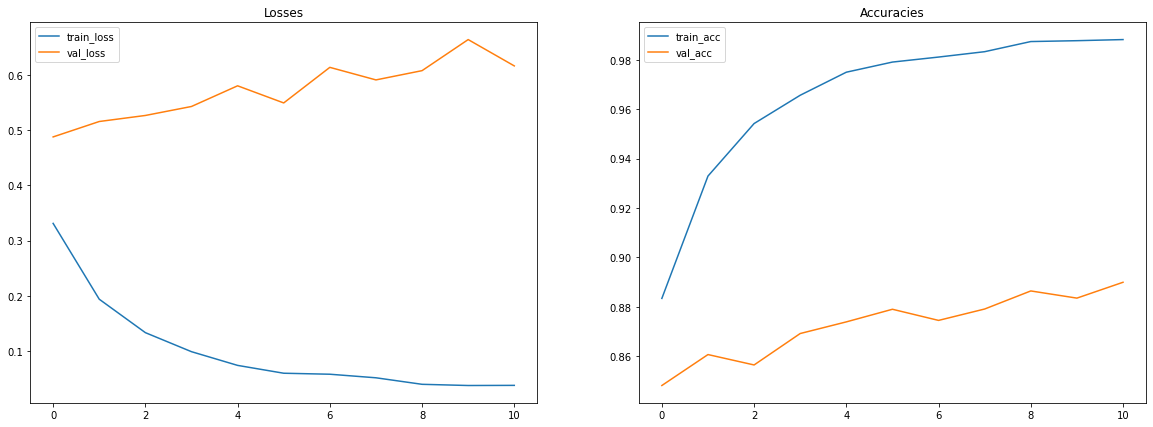

In [ ]:
plot_loss_curves(xception_history_ft)

In [ ]:
xception_model.evaluate(test_set_tfrecord, steps=(test_set_size // batch_size))

312/312 [==============================] - 14s 43ms/step - loss: 0.6106 - accuracy: 0.8896


[0.6106250286102295, 0.8896234035491943]

##### ResNet (`tf.keras.applications`)

In [ ]:
image_size = [128, 128]
batch_size = 32

tfds_train_data = tfds_train_data_raw.shuffle(1000).batch(batch_size).map(lambda x, y: preprocess_image(image_size, x, y, aug=False, norm=False)).prefetch(tf.data.AUTOTUNE)
tfds_valid_data = tfds_valid_data_raw.batch(batch_size).map(lambda x, y: preprocess_image(image_size, x, y, aug=False, norm=False)).prefetch(tf.data.AUTOTUNE)
tfds_test_data= tfds_test_data_raw.batch(batch_size).map(lambda x, y: preprocess_image(image_size, x, y, aug=False, norm=False)).prefetch(tf.data.AUTOTUNE)

In [ ]:
image_batch, label_batch = next(iter(tfds_train_data))

image_batch.shape, label_batch.shape

(TensorShape([32, 128, 128, 3]), TensorShape([32]))

In [ ]:
norm = tf.keras.layers.Normalization()
norm.adapt(image_batch)

In [ ]:
base_model = tf.keras.applications.resnet50.ResNet50(
    input_shape=(128, 128, 3),
    weights="imagenet",
    include_top=False
)

base_model.trainable = False

out = base_model(image_batch)
print(f"Output shape of the model: {out.shape}")
print(f"GlobalAveragePooling2D shape: {tf.keras.layers.GlobalAveragePooling2D()(out).shape}")

94765736/94765736 [==============================] - 6s 0us/step
Output shape of the model: (32, 4, 4, 2048)
GlobalAveragePooling2D shape: (32, 2048)


In [ ]:
len(base_model.layers) # number of layers in ResNet50 model

175

In [ ]:
train_data_size = tf.data.experimental.cardinality(tfds_train_data).numpy()
test_data_size = tf.data.experimental.cardinality(tfds_test_data).numpy()
valid_data_size = tf.data.experimental.cardinality(tfds_valid_data).numpy()

train_data_size, test_data_size, valid_data_size

(1329, 313, 235)

In [ ]:
# Normalized data

normalization = tf.keras.layers.Normalization()
normalization.adapt(tfds_train_data.map(lambda x, y: x))

In [ ]:
inputs = tf.keras.layers.Input(shape=(128, 128, 3))
x = normalization(inputs)
x = base_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(units=512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(units=256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(units=len(class_names), activation="softmax")(x)

Number of trainable layers of resnet_model_1: 6
Epoch 1/3
1329/1329 [==============================] - 104s 54ms/step - loss: 1.8243 - accuracy: 0.3142 - val_loss: 1.6948 - val_accuracy: 0.3505
Epoch 2/3
1329/1329 [==============================] - 65s 49ms/step - loss: 1.7914 - accuracy: 0.3306 - val_loss: 1.7621 - val_accuracy: 0.3300
Epoch 3/3
1329/1329 [==============================] - 64s 48ms/step - loss: 1.7600 - accuracy: 0.3431 - val_loss: 1.6320 - val_accuracy: 0.4100


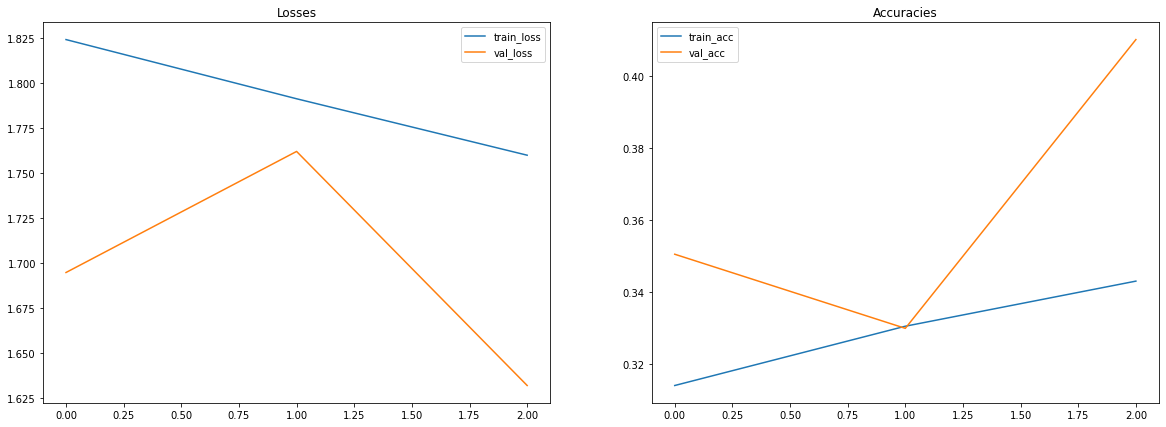

In [ ]:
epochs = 3

resnet_model_1 = tf.keras.Model(inputs, outputs)
print(f"Number of trainable layers of resnet_model_1: {len(resnet_model_1.trainable_variables)}")

resnet_model_1.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
                       loss=tf.keras.losses.sparse_categorical_crossentropy,
                       metrics=["accuracy"])

history_resnet_1 = resnet_model_1.fit(tfds_train_data, steps_per_epoch=train_data_size,
                                      validation_data=tfds_valid_data, validation_steps=valid_data_size,
                                      epochs=epochs)

plot_loss_curves(history_resnet_1)

In [ ]:
# Non-normalized data

image_size = [128, 128]
batch_size = 128

tfds_train_data_aug = tfds_train_data_raw.shuffle(1000).batch(batch_size).map(lambda x, y: preprocess_image(image_size, x, y, aug=True, norm=False)).prefetch(tf.data.AUTOTUNE)
tfds_train_data = tfds_train_data_raw.shuffle(10000).batch(batch_size).map(lambda x, y: preprocess_image(image_size, x, y, aug=True, norm=False)).prefetch(tf.data.AUTOTUNE)

tfds_train_data = tfds_train_data.concatenate(tfds_train_data_aug)
tfds_valid_data = tfds_valid_data_raw.batch(batch_size).map(lambda x, y: preprocess_image(image_size, x, y, aug=False, norm=False)).prefetch(tf.data.AUTOTUNE)
tfds_test_data= tfds_test_data_raw.batch(batch_size).map(lambda x, y: preprocess_image(image_size, x, y, aug=False, norm=False)).prefetch(tf.data.AUTOTUNE)

In [ ]:
inputs = tf.keras.layers.Input(shape=(128, 128, 3))
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(units=512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(units=256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(units=len(class_names), activation="softmax")(x)

Number of trainable layers of resnet_model_2: 6
Epoch 1/3
1329/1329 [==============================] - 68s 49ms/step - loss: 1.2134 - accuracy: 0.6299 - val_loss: 0.8905 - val_accuracy: 0.7296
Epoch 2/3
1329/1329 [==============================] - 69s 52ms/step - loss: 1.0340 - accuracy: 0.6761 - val_loss: 0.7733 - val_accuracy: 0.7632
Epoch 3/3
1329/1329 [==============================] - 67s 50ms/step - loss: 0.9675 - accuracy: 0.6997 - val_loss: 0.7901 - val_accuracy: 0.7516


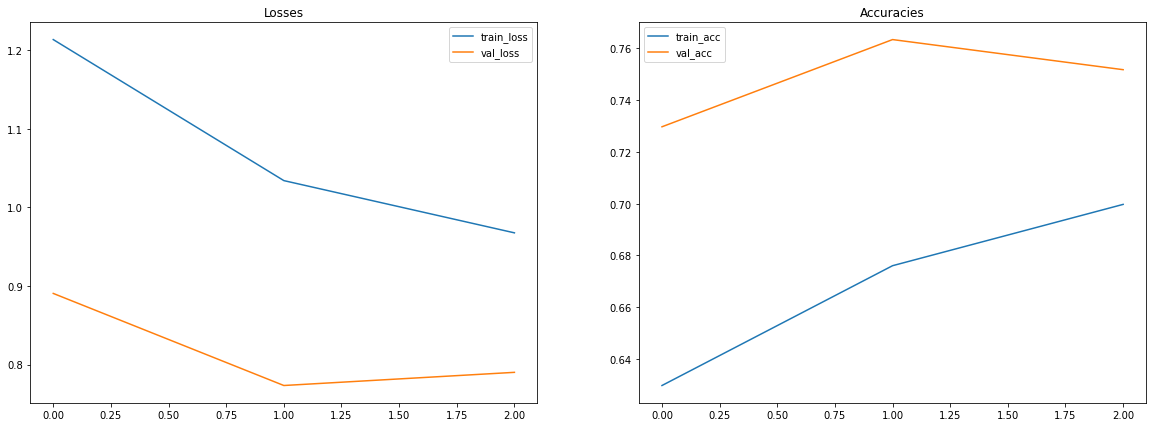

In [ ]:
epochs = 3

resnet_model_2 = tf.keras.Model(inputs, outputs)
print(f"Number of trainable layers of resnet_model_2: {len(resnet_model_2.trainable_variables)}")

resnet_model_2.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
                       loss=tf.keras.losses.sparse_categorical_crossentropy,
                       metrics=["accuracy"])

history_resnet_2 = resnet_model_2.fit(tfds_train_data, steps_per_epoch=train_data_size,
                                      validation_data=tfds_valid_data, validation_steps=valid_data_size,
                                      epochs=epochs)

plot_loss_curves(history_resnet_2)

In [ ]:
# Add batch norm

inputs = tf.keras.layers.Input(shape=(128, 128, 3))
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(units=256, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(units=256, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(units=128, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(units=len(class_names), activation="softmax")(x)

epochs = 5

resnet_model_3 = tf.keras.Model(inputs, outputs)
print(f"Number of trainable layers of resnet_model_3: {len(resnet_model_3.trainable_variables)}")

resnet_model_3.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01, decay=0.001),
                       loss=tf.keras.losses.sparse_categorical_crossentropy,
                       metrics=["accuracy"])

history_resnet_3 = resnet_model_3.fit(tfds_train_data, steps_per_epoch=train_data_size,
                                      validation_data=tfds_valid_data, validation_steps=valid_data_size,
                                      epochs=epochs)

Number of trainable layers of resnet_model_3: 16
Epoch 1/5
666/666 [==============================] - 97s 136ms/step - loss: 0.6224 - accuracy: 0.7864 - val_loss: 0.5565 - val_accuracy: 0.8136
Epoch 2/5
666/666 [==============================] - 90s 134ms/step - loss: 0.4052 - accuracy: 0.8602 - val_loss: 0.5479 - val_accuracy: 0.8243
Epoch 3/5
666/666 [==============================] - 93s 140ms/step - loss: 0.2998 - accuracy: 0.8960 - val_loss: 0.5743 - val_accuracy: 0.8235
Epoch 4/5
666/666 [==============================] - 90s 134ms/step - loss: 0.2225 - accuracy: 0.9218 - val_loss: 0.5927 - val_accuracy: 0.8349
Epoch 5/5
666/666 [==============================] - 90s 135ms/step - loss: 0.1640 - accuracy: 0.9428 - val_loss: 0.6320 - val_accuracy: 0.8328


In [ ]:
resnet_model_3.evaluate(tfds_test_data, steps=test_data_size)

79/79 [==============================] - 10s 126ms/step - loss: 0.6262 - accuracy: 0.8343


[0.6262253522872925, 0.8342999815940857]

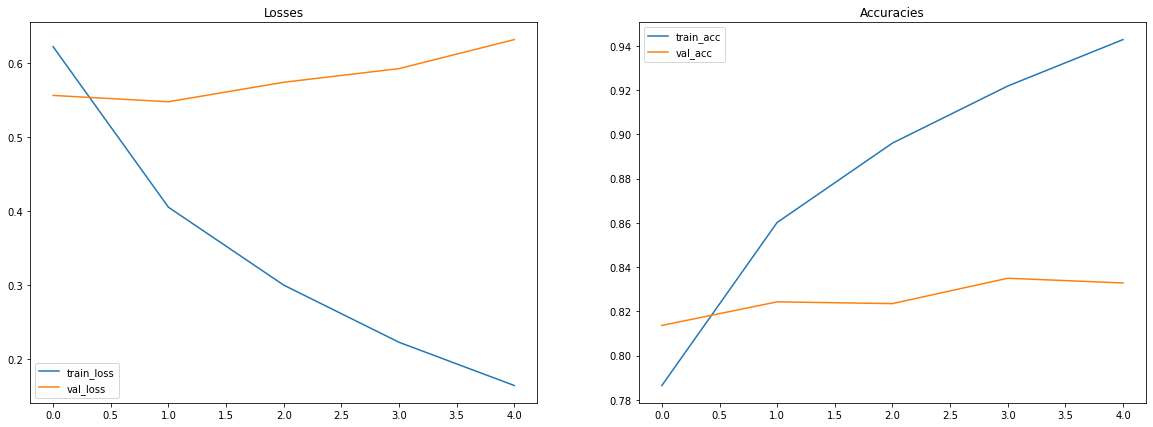

In [ ]:
plot_loss_curves(history_resnet_3)

In [ ]:
base_model.trainable = True

fine_tune_at = 0.75 # 75% 

for layer in base_model.layers[:int(len(base_model.layers) * fine_tune_at)]:
  layer.trainable = False

Epoch 5/10
666/666 [==============================] - 134s 192ms/step - loss: 0.3213 - accuracy: 0.8977 - val_loss: 0.6345 - val_accuracy: 0.8337
Epoch 6/10
666/666 [==============================] - 127s 190ms/step - loss: 0.1550 - accuracy: 0.9454 - val_loss: 0.6090 - val_accuracy: 0.8397
Epoch 7/10
666/666 [==============================] - 127s 190ms/step - loss: 0.1157 - accuracy: 0.9593 - val_loss: 0.5981 - val_accuracy: 0.8420
Epoch 8/10
666/666 [==============================] - 127s 190ms/step - loss: 0.0967 - accuracy: 0.9671 - val_loss: 0.5906 - val_accuracy: 0.8445
Epoch 9/10
666/666 [==============================] - 126s 189ms/step - loss: 0.0831 - accuracy: 0.9727 - val_loss: 0.5898 - val_accuracy: 0.8432
Epoch 10/10
79/79 [==============================] - 10s 121ms/step - loss: 0.5710 - accuracy: 0.8458
[0.571037232875824, 0.84579998254776]


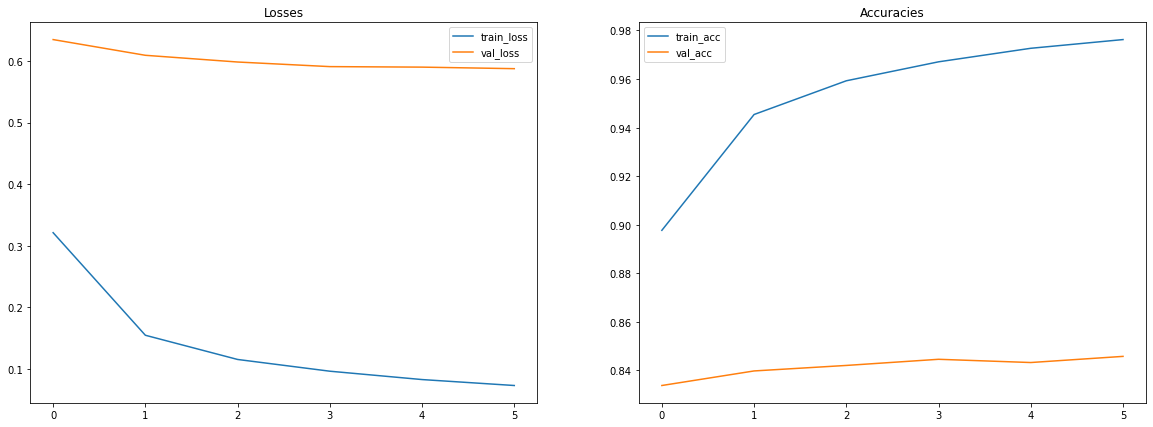

In [ ]:
fine_tune_epochs = 5
total_epochs = fine_tune_epochs + epochs

resnet_model_3.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-5, decay=0.0001),
                       loss=tf.keras.losses.sparse_categorical_crossentropy,
                       metrics=["accuracy"])

ft_history_resnet_model_3 = resnet_model_3.fit(tfds_train_data, steps_per_epoch=train_data_size,
                                                validation_data=tfds_valid_data, validation_steps=valid_data_size,
                                                epochs=total_epochs, initial_epoch=history_resnet_3.epoch[-1])

print(resnet_model_3.evaluate(tfds_test_data, steps=test_data_size))
plot_loss_curves(ft_history_resnet_model_3)

Number of trainable layers of resnet_model_4: 14
Epoch 1/5
1329/1329 [==============================] - 71s 50ms/step - loss: 0.7881 - accuracy: 0.7347 - val_loss: 0.5967 - val_accuracy: 0.7881
Epoch 2/5
1329/1329 [==============================] - 65s 49ms/step - loss: 0.6117 - accuracy: 0.7918 - val_loss: 0.5906 - val_accuracy: 0.7939
Epoch 3/5
1329/1329 [==============================] - 66s 49ms/step - loss: 0.5634 - accuracy: 0.8080 - val_loss: 0.5650 - val_accuracy: 0.8081
Epoch 4/5
1329/1329 [==============================] - 66s 49ms/step - loss: 0.5243 - accuracy: 0.8219 - val_loss: 0.5756 - val_accuracy: 0.8064
Epoch 5/5
1329/1329 [==============================] - 67s 50ms/step - loss: 0.4947 - accuracy: 0.8319 - val_loss: 0.5776 - val_accuracy: 0.8077


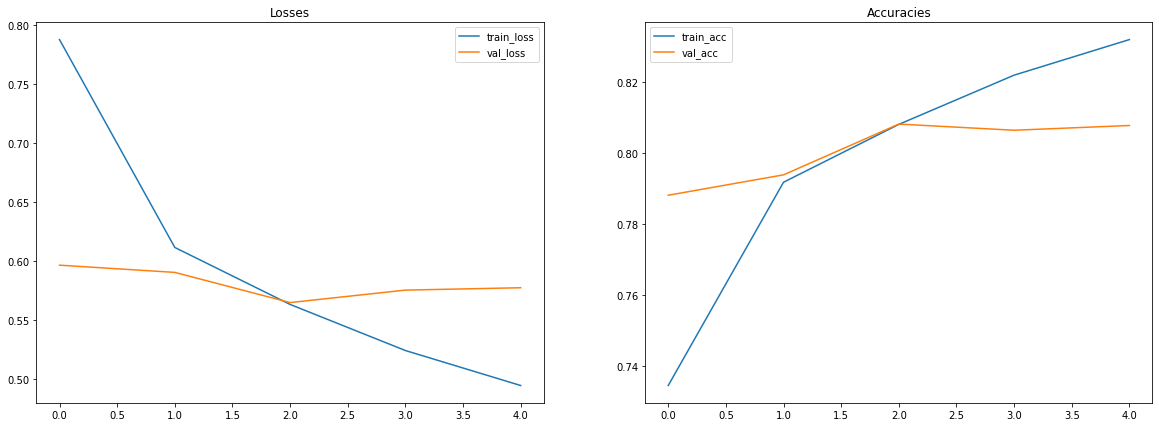

In [ ]:
inputs = tf.keras.layers.Input(shape=(128, 128, 3))
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(units=512, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(units=256, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(units=128, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(units=len(class_names), activation="softmax")(x)

epochs = 5

resnet_model_4 = tf.keras.Model(inputs, outputs)
print(f"Number of trainable layers of resnet_model_4: {len(resnet_model_4.trainable_variables)}")

resnet_model_4.compile(optimizer=tf.keras.optimizers.Adam(lr=0.008),
                       loss=tf.keras.losses.sparse_categorical_crossentropy,
                       metrics=["accuracy"])

history_resnet_4 = resnet_model_4.fit(tfds_train_data, steps_per_epoch=train_data_size,
                                      validation_data=tfds_valid_data, validation_steps=valid_data_size,
                                      epochs=epochs)

plot_loss_curves(history_resnet_4)

In [ ]:
base_model.trainable = True

fine_tune_at = 120

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
fine_tune_epochs = 5
total_epochs = fine_tune_epochs + epochs

resnet_model_4.compile(optimizer=tf.keras.optimizers.Adam(lr=0.008 / 10, decay=0.001),
                       loss=tf.keras.losses.sparse_categorical_crossentropy,
                       metrics=["accuracy"])

ft_history_resnet_model_4 = resnet_model_4.fit(tfds_train_data, steps_per_epoch=train_data_size,
                                                validation_data=tfds_valid_data, validation_steps=valid_data_size,
                                                epochs=total_epochs, initial_epoch=history_resnet_4.epoch[-1])

Epoch 5/10
1329/1329 [==============================] - 162s 78ms/step - loss: 0.5197 - accuracy: 0.8317 - val_loss: 0.3324 - val_accuracy: 0.8869
Epoch 6/10
1329/1329 [==============================] - 101s 76ms/step - loss: 0.2290 - accuracy: 0.9260 - val_loss: 0.2699 - val_accuracy: 0.9097
Epoch 7/10
1329/1329 [==============================] - 101s 76ms/step - loss: 0.0997 - accuracy: 0.9690 - val_loss: 0.2520 - val_accuracy: 0.9205
Epoch 8/10
1329/1329 [==============================] - 107s 80ms/step - loss: 0.0485 - accuracy: 0.9856 - val_loss: 0.2688 - val_accuracy: 0.9180
Epoch 9/10
1329/1329 [==============================] - 104s 78ms/step - loss: 0.0297 - accuracy: 0.9916 - val_loss: 0.2747 - val_accuracy: 0.9231
Epoch 10/10
1329/1329 [==============================] - 103s 78ms/step - loss: 0.0211 - accuracy: 0.9940 - val_loss: 0.2936 - val_accuracy: 0.9213


In [ ]:
resnet_model_4.evaluate(tfds_test_data, steps=test_data_size)

313/313 [==============================] - 14s 43ms/step - loss: 0.3349 - accuracy: 0.9179


[0.3349001705646515, 0.917900025844574]